In [1]:
import os,sys
sys.path.append("/Users/adityarotti/Documents/Work/Projects/spectral_distortions_frgs/analysis/")

from modules import return_sed
from scipy.optimize import curve_fit
from scipy import optimize as optz
import collections
import pandas as pd

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
import healpy as h
npixtot=h.nside2npix(512)
figpath="./results/"
ensure_dir(figpath)
        
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Direct fitting

In [95]:
components=["cmb","sync","dust"]
max_der=2
rsed=return_sed.init_model_sed(components,max_der=max_der,units="uKRJ",nu_ref_low=1.,normalize=False)
rsed.setup_ana_sed(max_der=max_der,min_der=2,beta_dust_max=max_der,sl_dust_max=max_der,sl_sync_max=max_der)

fn_unit_conv={}
fn_unit_conv["uK"]=rsed.ssed.fn_sed["fn_bb_dT"]
fn_unit_conv["uKRJ"]=rsed.ssed.fn_sed["fn_bb_RJ"]

fit_order=[0,2]
fn={}
guess={}
bounds={}

guess_pivot=[20.,1.5,-1.]

fn_guess=lambda nu,Ac,Ad,As : (
    rsed.fn_sed["cmb"](nu,Ac) 
    + rsed.fn_sed["dust"](nu,Ad,1./20.,1.5) 
    + rsed.fn_sed["sync"](nu,As,-1.)
)

fn[0]=lambda nu,Td,sld,sls,Ac,Ad,As : (
    rsed.fn_sed["cmb"](nu,Ac) 
    + rsed.fn_sed["dust"](nu,Ad,1./Td,sld) 
    + rsed.fn_sed["sync"](nu,As,sls)
)

lb=[0.,0.,-3.] + 3*[-np.Inf]
ub=[30.,5.,2.] + 3*[np.Inf]
bounds[0]=(lb,ub)

fn[2]=lambda nu,Td,sld,sls,Ac,Ad,As,Ad02,Ad11,Ad20,As2 : (
    rsed.fn_sed["cmb"](nu,Ac) 
    + rsed.fn_sed["dust"](nu,Ad,1./Td,sld)
    + rsed.fn_sed['beta_dust_00_sl_dust_02'](nu,Ad02,1./Td,sld) 
    + rsed.fn_sed['beta_dust_01_sl_dust_01'](nu,Ad11,1./Td,sld) 
    + rsed.fn_sed['beta_dust_02_sl_dust_00'](nu,Ad20,1./Td,sld) 
    + rsed.fn_sed["sync"](nu,As,sls)
    + rsed.fn_sed['sl_sync_02'](nu,As2,sls)
)
lb=[0.,0.,-3.] + 7*[-np.Inf]
ub=[30.,5.,2.] + 7*[np.Inf]
bounds[2]=(lb,ub)

In [96]:
# fit_order=[0,2]
# fn={}
# guess={}
# bounds={}

# fn[0]=lambda nu,Td,sld,sls,Ad,As : (
#     rsed.fn_sed["dust"](nu,Ad,1./Td,sld) 
#     + rsed.fn_sed["sync"](nu,As,sls)
# )
# guess[0]=[20.,1.5,-1.,0.,0.]
# lb=[0.,0.,-3.] + 2*[-np.Inf]
# ub=[40.,5.,3.] + 2*[np.Inf]
# bounds[0]=(lb,ub)

# fn[2]=lambda nu,Td,sld,sls,Ad,As,Ad02,Ad11,Ad20,As2 : (
#     rsed.fn_sed["dust"](nu,Ad,1./Td,sld)
#     + rsed.fn_sed['beta_dust_00_sl_dust_02'](nu,Ad02,1./Td,sld) 
#     + rsed.fn_sed['beta_dust_01_sl_dust_01'](nu,Ad11,1./Td,sld) 
#     + rsed.fn_sed['beta_dust_02_sl_dust_00'](nu,Ad20,1./Td,sld) 
#     + rsed.fn_sed["sync"](nu,As,sls)
#     + rsed.fn_sed['sl_sync_02'](nu,As2,sls)
# )
# guess[2]=[20.,1.5,-1.,0.,0.,0.,0.,0.,0.]
# lb=[0.,0.,-3.] + 6*[-np.Inf]
# ub=[40.,5.,3.] + 6*[np.Inf]
# bounds[2]=(lb,ub)

# Get data

In [97]:
simulations=["PICO","PICO_MHD","LiteBIRD"]
fnames={}
fnames["PICO"]="./pico_d1s1_fullsky_sed.txt"
fnames["PICO_MHD"]="./pico_mhd_fullsky_sed.txt"
fnames["LiteBIRD"]="./litebird_fullsky_sed.txt"

# The ordering of sed_type follows the columns of the data file
amp=1e7
data_type=["channels","Mean SED", "RMS SED","SED ERR", "Mean SED NF"]
sed={}
for sim in simulations:
    data=np.loadtxt(fnames[sim])
    sed[sim]={}
    for i,stype in enumerate(data_type):
        if "Mean" in stype:
            print stype
            sed[sim][stype]=data[:,i]*amp
        else:
            sed[sim][stype]=data[:,i]    
            
sed_type=["Mean SED", "RMS SED", "Mean SED NF"]


# Unit conversion
unit_conv={}
for sim in simulations:
    if "PICO" in sim:
        unit_conv[sim]=fn_unit_conv["uK"](sed[sim]["channels"])*1e6/fn_unit_conv["uKRJ"](sed[sim]["channels"])
    else:
        unit_conv[sim]=fn_unit_conv["uK"](sed[sim]["channels"])/fn_unit_conv["uKRJ"](sed[sim]["channels"])
    for stype in sed_type + ["SED ERR"]:
        sed[sim][stype]=sed[sim][stype]*unit_conv[sim]

Mean SED
Mean SED NF
Mean SED
Mean SED NF
Mean SED
Mean SED NF


# Fitting analysis

## Direct brute force fitting

In [44]:
figpath="./results/direct_fit/"
ensure_dir(figpath)

In [50]:
fo=2
sim="PICO"
stype="Mean SED"
temp_fn=lambda pars : ((fn[fo](sed[sim]["channels"],*pars)-sed[sim][stype]))

# x=optz.leastsq(temp_fn,x0=pivots[sim][stype][fo],maxfev=100000)
soln=optz.least_squares(temp_fn,x0=guess[fo],bounds=bounds[fo],verbose=2,xtol=1e-3,ftol=1e-3)
soln["x"]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0440e+02                                    2.08e+19    
       1              4         9.6844e+00      9.47e+01       2.99e-01       8.08e+18    
       2              5         4.5163e+00      5.17e+00       5.93e-01       5.73e+18    
       3              6         5.2610e-02      4.46e+00       1.19e+00       6.41e+17    
       4             11         5.2610e-02      0.00e+00       0.00e+00       6.41e+17    
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 1.0440e+02, final cost 5.2610e-02, first-order optimality 6.41e+17.


array([  2.00663358e+01,   1.50058897e+00,  -9.78929574e-01,
         2.28386225e-01,  -4.48969340e-01,  -1.40512826e-17,
        -2.52882258e-01,   3.79503372e-03,   3.85459801e-04,
        -1.64399276e-18])

In [94]:
amp_guess=optz.curve_fit(fn_guess,chnls,sed[sim][stype][fo])

In [99]:
guess_pivot

[20.0, 1.5, -1.0]

In [59]:
columns=["Simulation","SED Type","Moment order",r"$T_{\rm dust}$",r"$\beta_{\rm dust}$",r"$\beta_{\rm sync.}$"]
dresult=collections.OrderedDict()
for tag in columns:
    dresult[tag]=[]
    
pivots={}
for sim in simulations:
    pivots[sim]={}
    for stype in sed_type:
        pivots[sim][stype]={}
        guess=None
        for fo in fit_order:
            dresult["Simulation"]=dresult["Simulation"] + [sim]
            dresult["SED Type"]=dresult["SED Type"] + [stype]
            dresult["Moment order"]=dresult["Moment order"] + [fo]
            p0,p0_cov=curve_fit(fn[fo],
                                sed[sim]["channels"],
                                sed[sim][stype] + np.random.normal(loc=np.zeros(len(sed[sim]["SED ERR"])),scale=sed[sim]["SED ERR"]*1e3),
                                sigma=sed[sim]["SED ERR"]*1e3,
                                absolute_sigma=False,
                                p0=guess_pivots,
                                bounds=bounds[fo],
                                maxfev=200000)
            dresult[r"$T_{\rm dust}$"]=dresult[r"$T_{\rm dust}$"] + [p0[0]]
            dresult[r"$\beta_{\rm dust}$"]=dresult[r"$\beta_{\rm dust}$"] + [p0[1]]
            dresult[r"$\beta_{\rm sync.}$"]=dresult[r"$\beta_{\rm sync.}$"] + [p0[2]-2]
#             guess_pivots=np.append(p0[:3],np.zeros(7))
            guess_pivots=np.append(p0,np.zeros(4))
            pivots[sim][stype][fo]=p0
            print sim, stype,fo,p0[:3]
    

PICO Mean SED 0 [ 20.    1.5  -1. ]
PICO Mean SED 2 [ 18.65648817   1.49225307  -1.08875648]
PICO RMS SED 0 [ 19.90546847   1.36649598  -0.94365809]
PICO RMS SED 2 [ 19.90464222   1.34313289  -0.94770875]
PICO Mean SED NF 0 [ 20.    1.5  -1. ]
PICO Mean SED NF 2 [ 20.04398886   1.47112032  -0.94177488]
PICO_MHD Mean SED 0 [ 20.    1.5  -1. ]
PICO_MHD Mean SED 2 [ 20.33645646   1.50108696  -1.02248016]
PICO_MHD RMS SED 0 [ 20.01991528   1.5293801   -0.99826592]
PICO_MHD RMS SED 2 [ 20.0147432    1.47872157  -1.02187649]
PICO_MHD Mean SED NF 0 [ 20.    1.5  -1. ]
PICO_MHD Mean SED NF 2 [ 19.9961297    1.49813257  -1.04007289]
LiteBIRD Mean SED 0 [ 19.97880816   1.57134036  -1.04767513]
LiteBIRD Mean SED 2 [ 19.98374473   1.57758559  -1.03370952]
LiteBIRD RMS SED 0 [ 26.98417178   1.38418055  -1.18158004]
LiteBIRD RMS SED 2 [ 26.98417178   1.38418055  -1.18158004]
LiteBIRD Mean SED NF 0 [ 19.97510353   1.51911497  -1.02414146]
LiteBIRD Mean SED NF 2 [ 19.97510353   1.51911497  -1.02414146

In [54]:
dfit_stat=pd.DataFrame(dresult)
dfit_stat.set_index(["Simulation","SED Type"],inplace=True)
dfit_stat

Moment order  $T_{\rm dust}$  $\beta_{\rm dust}$  \
Simulation SED Type                                                        
PICO       Mean SED                0       20.000000            1.500000   
           Mean SED                2       20.000000            1.500000   
           RMS SED                 0       20.000058            1.500086   
           RMS SED                 2       20.077194            1.439289   
           Mean SED NF             0       20.000000            1.500000   
           Mean SED NF             2       20.157623            1.472789   
PICO_MHD   Mean SED                0       20.000000            1.500000   
           Mean SED                2       20.000000            1.500000   
           RMS SED                 0       20.000000            1.500000   
           RMS SED                 2       20.033341            1.493373   
           Mean SED NF             0       20.000000            1.500000   
           Mean SED NF             2       20.000000            1.500000   
LiteBIRD   Mean SED                0       20.000000            1.500000   
           Mean SED                2       19.995249            1.504490   
           RMS SED                 0       20.020731            1.561613   
           RMS SED                 2       20.002185            1.570947   
           Mean SED NF             0       20.000000            1.500000   
           Mean SED NF             2       19.991481            1.512403   

                        $\beta_{\rm sync.}$  
Simulation SED Type                          
PICO       Mean SED               -3.000000  
           Mean SED               -3.000000  
           RMS SED                -3.000000  
           RMS SED                -2.931564  
           Mean SED NF            -3.000000  
           Mean SED NF            -2.940276  
PICO_MHD   Mean SED               -3.000000  
           Mean SED               -3.000000  
           RMS SED                -3.000000  
           RMS SED                -2.963820  
           Mean SED NF            -3.000000  
           Mean SED NF            -3.000000  
LiteBIRD   Mean SED               -3.000000  
           Mean SED               -3.002164  
           RMS SED                -4.583540  
           RMS SED                -4.601683  
           Mean SED NF            -3.000000  
           Mean SED NF            -3.037788

<IPython.core.display.Javascript object>


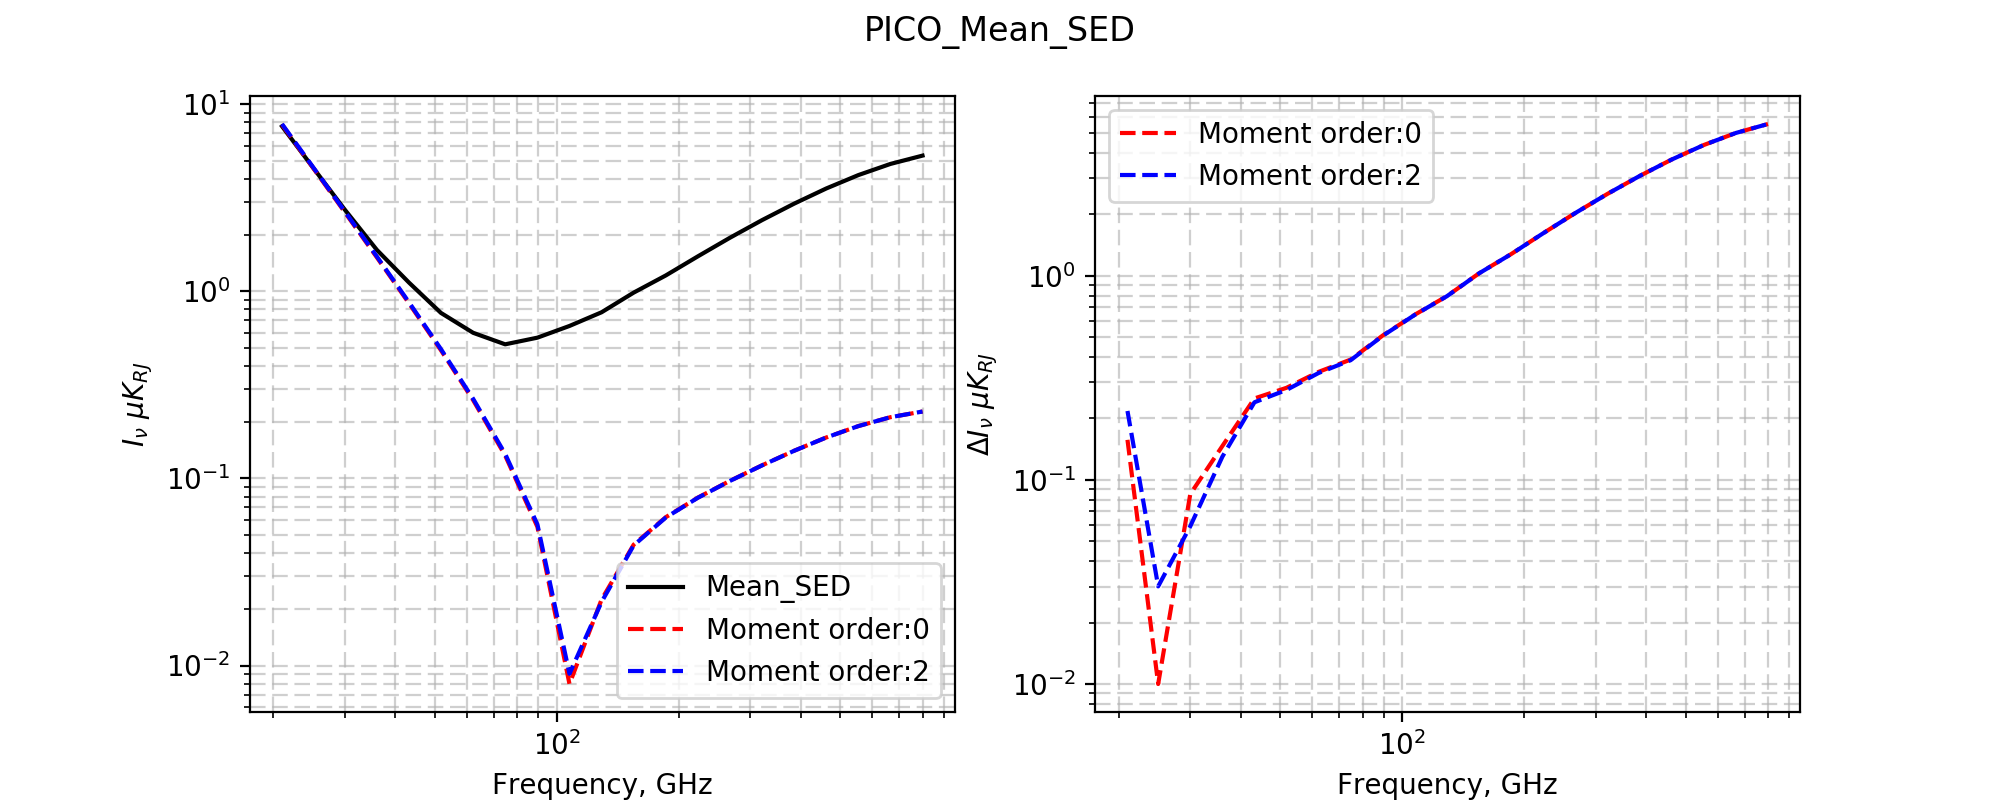

<IPython.core.display.Javascript object>


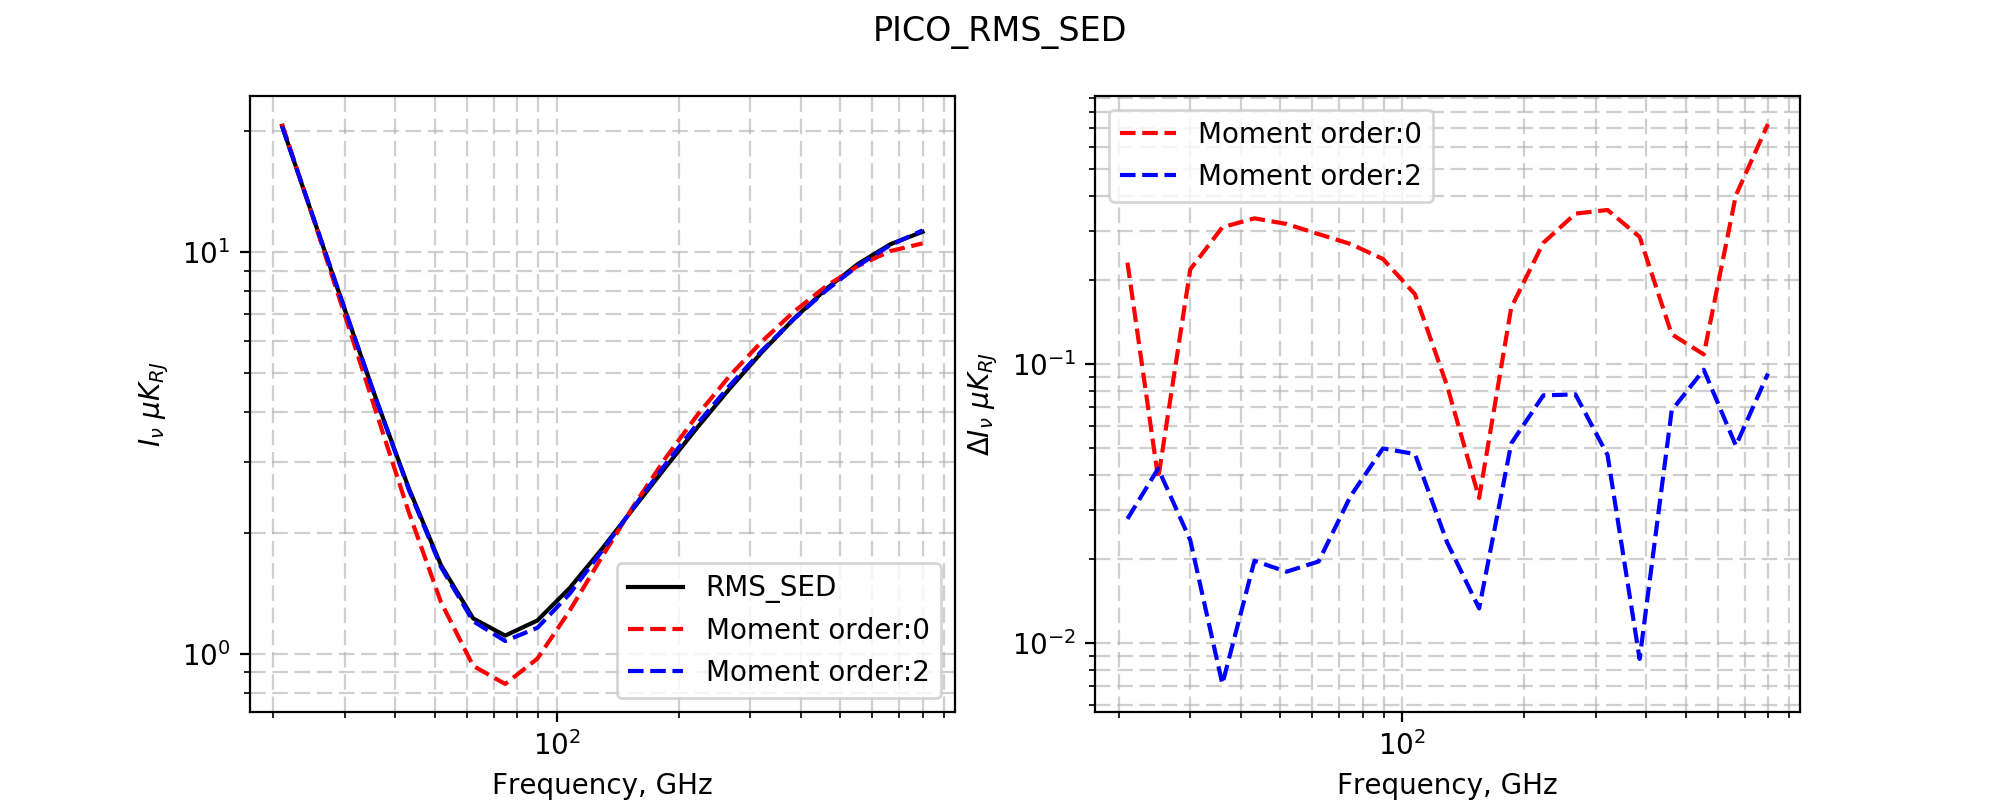

<IPython.core.display.Javascript object>


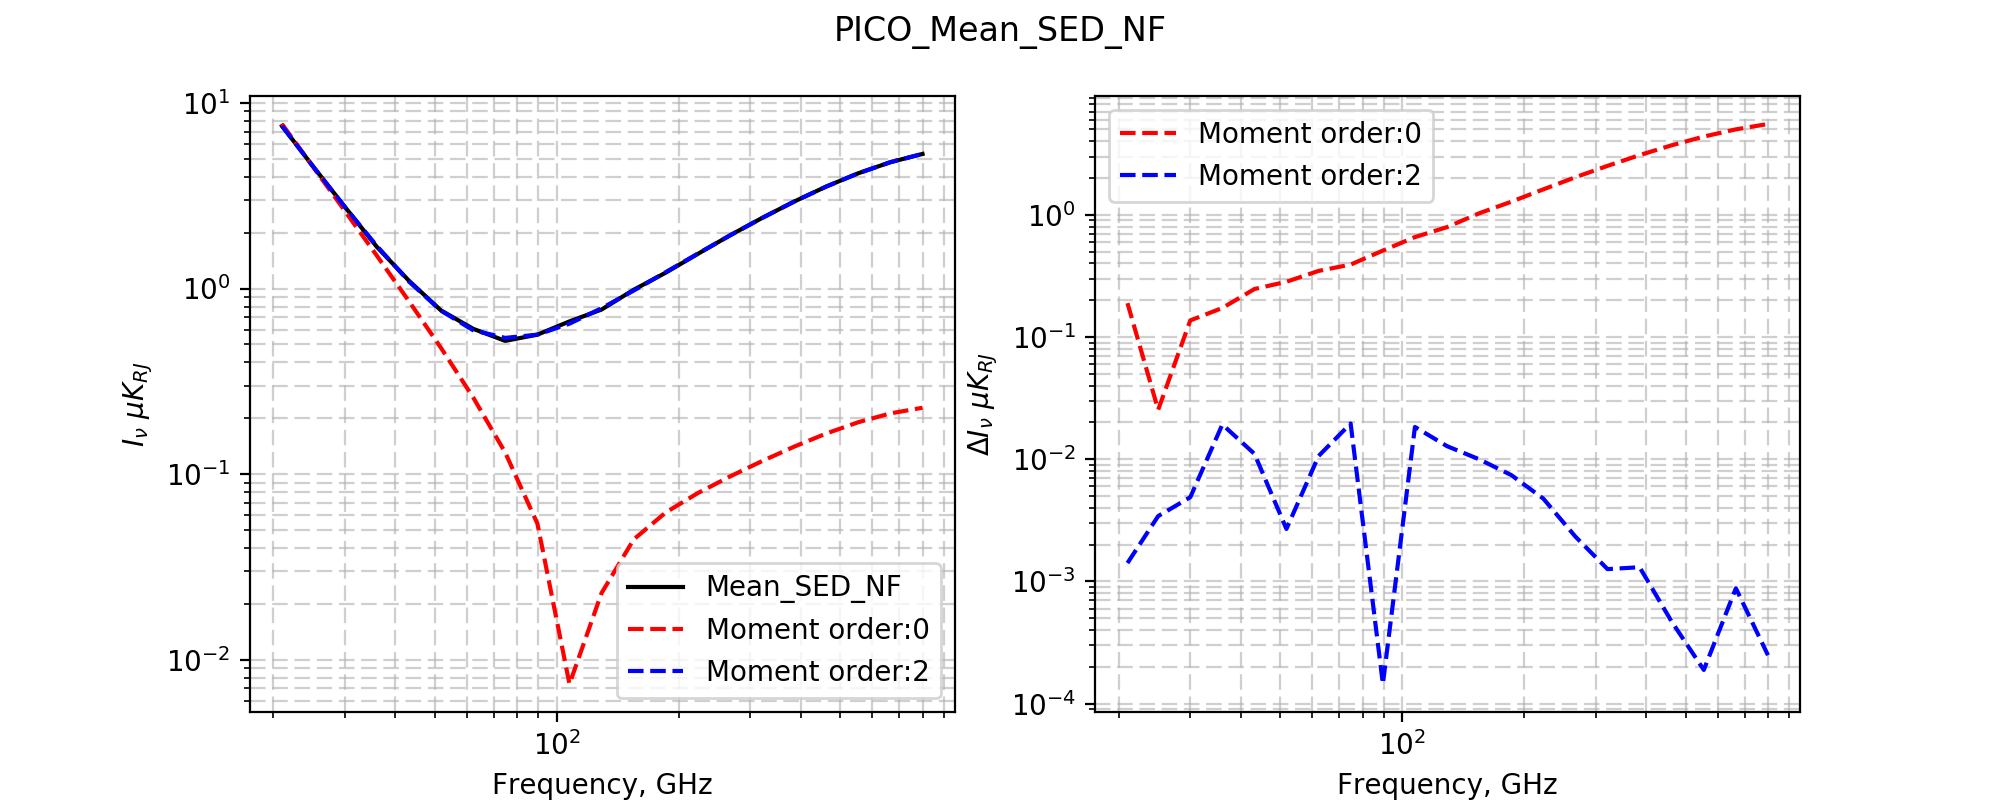

<IPython.core.display.Javascript object>


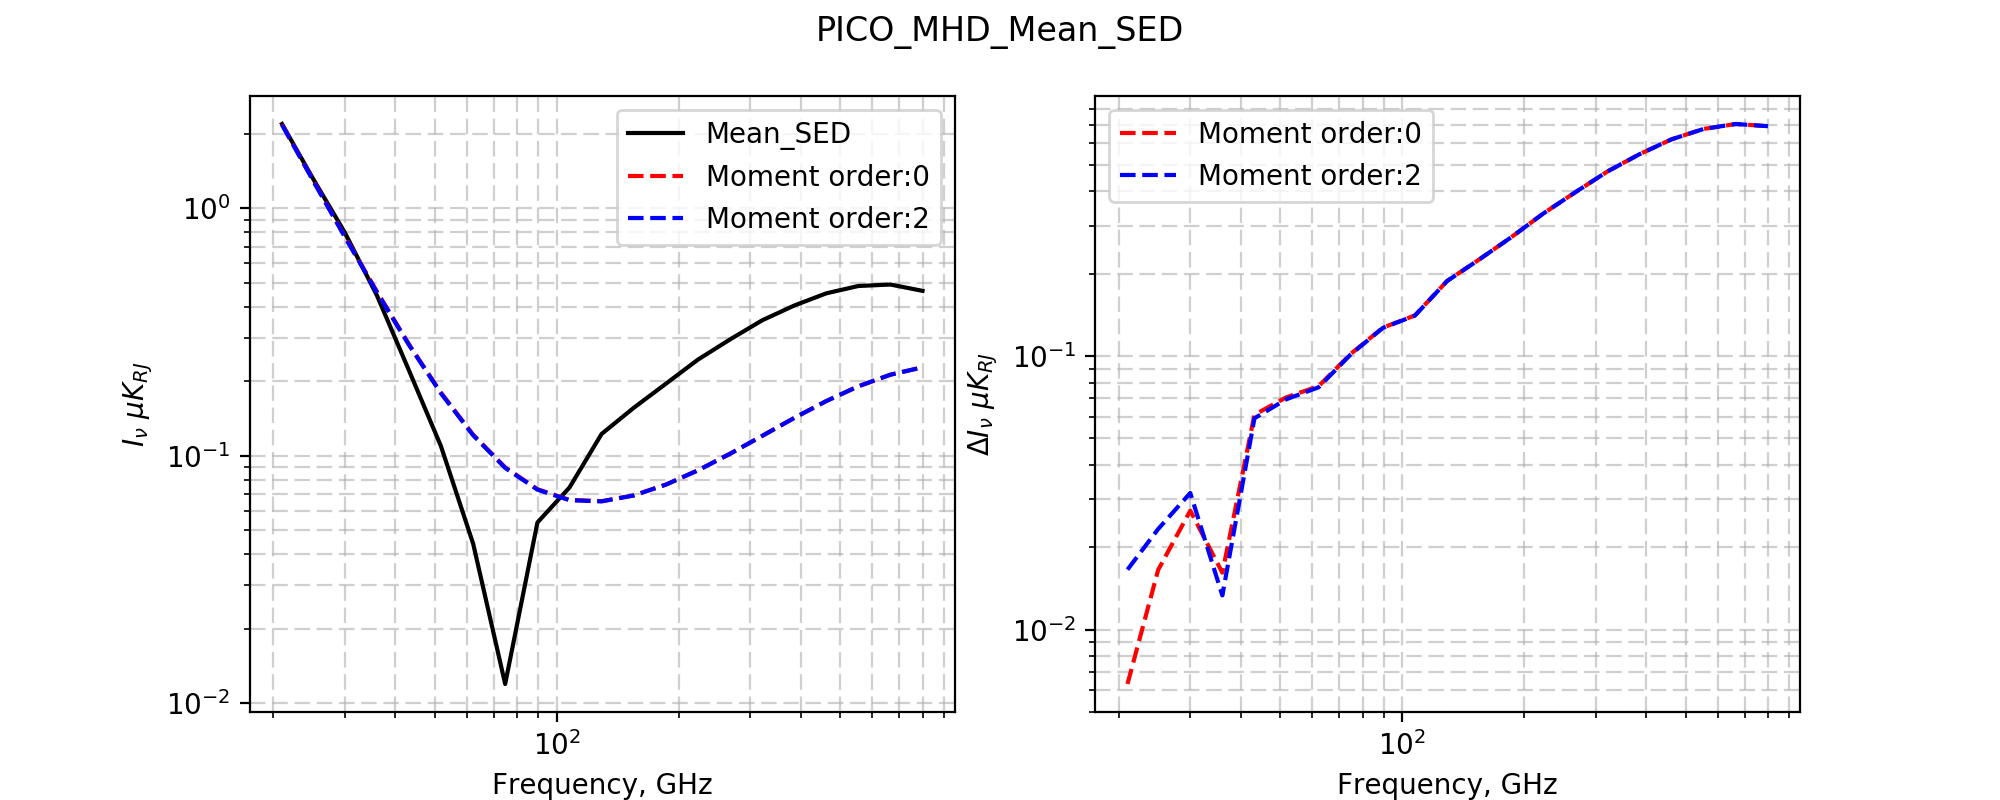

<IPython.core.display.Javascript object>


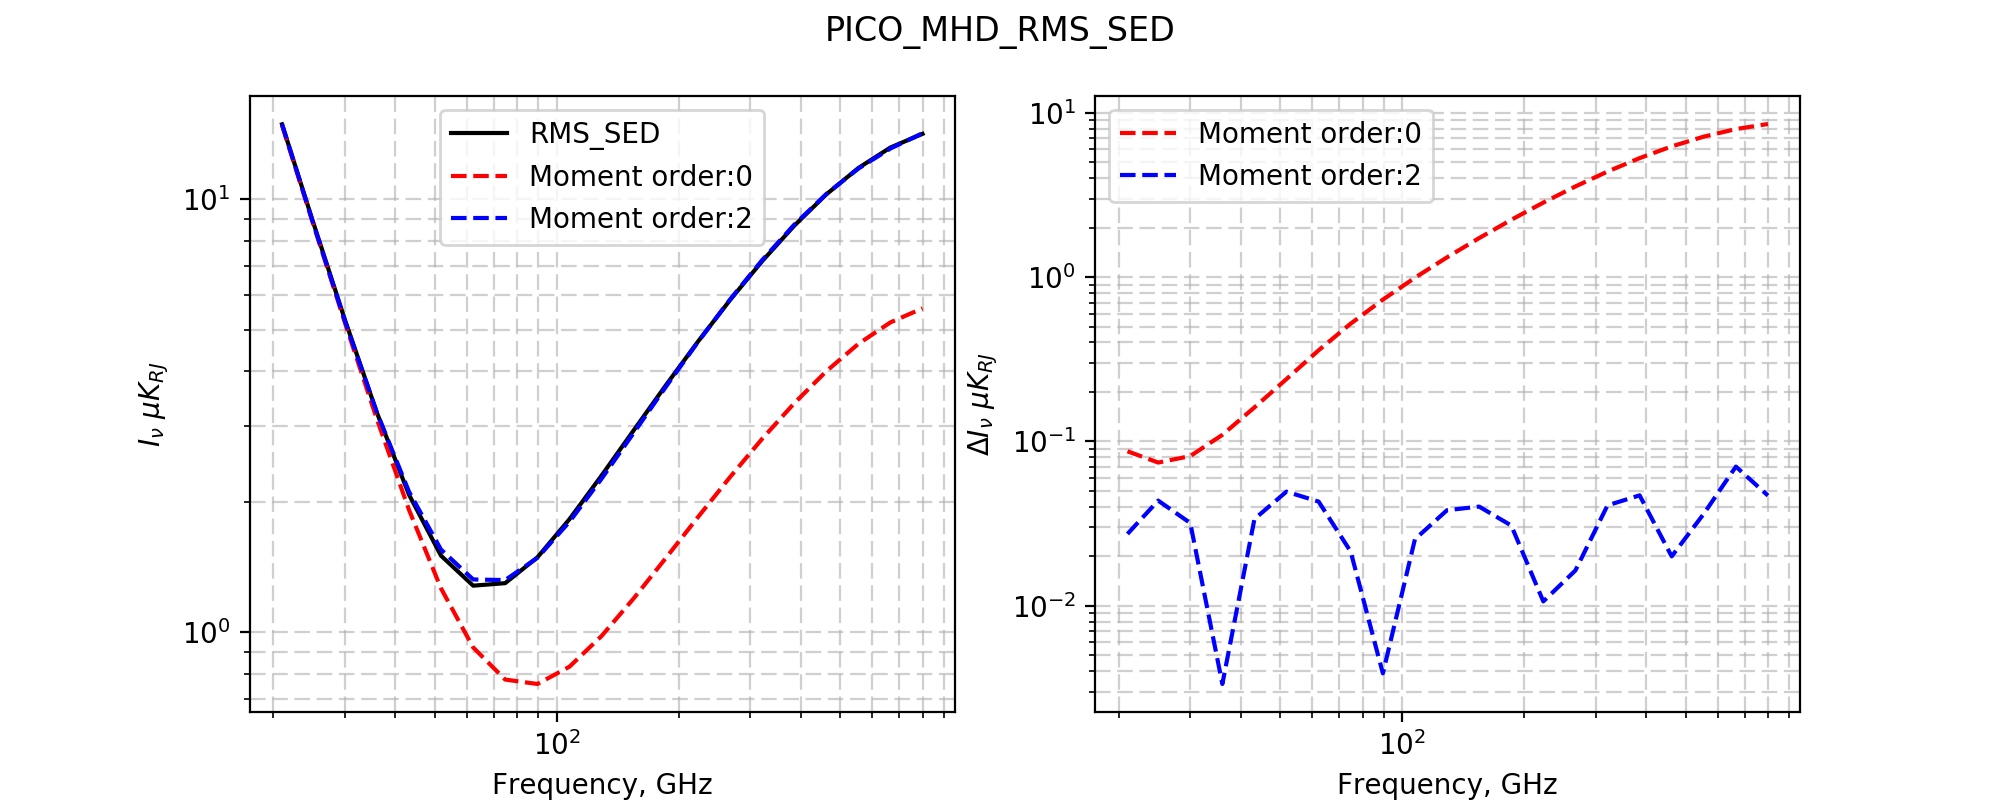

<IPython.core.display.Javascript object>


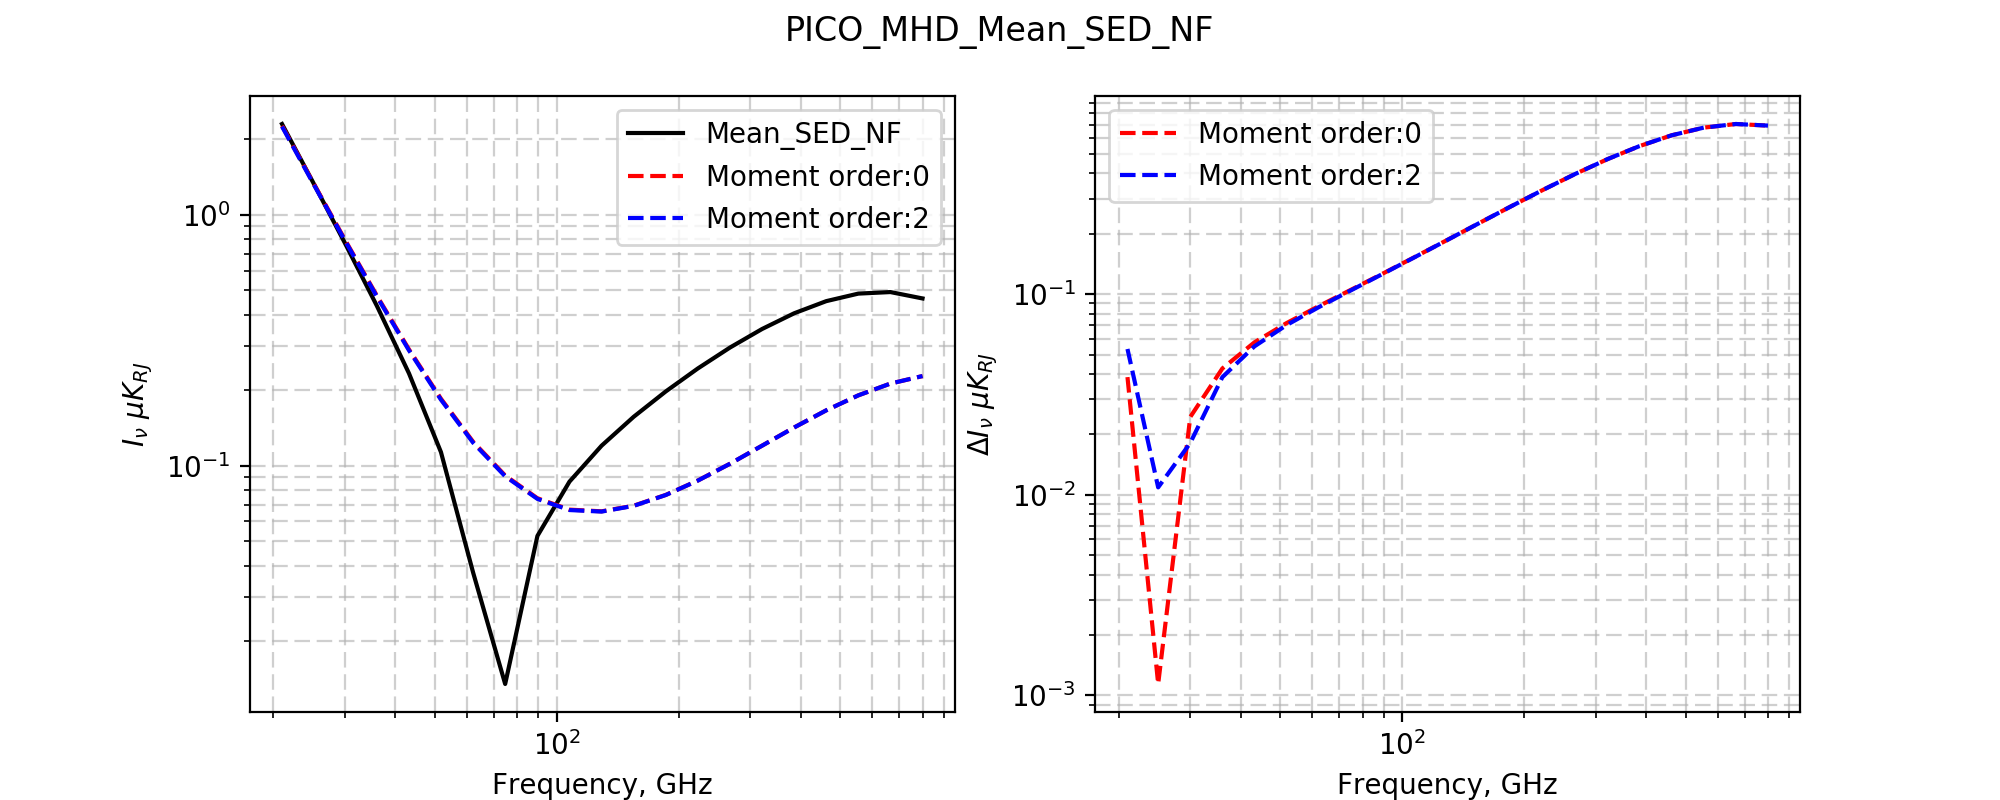

<IPython.core.display.Javascript object>


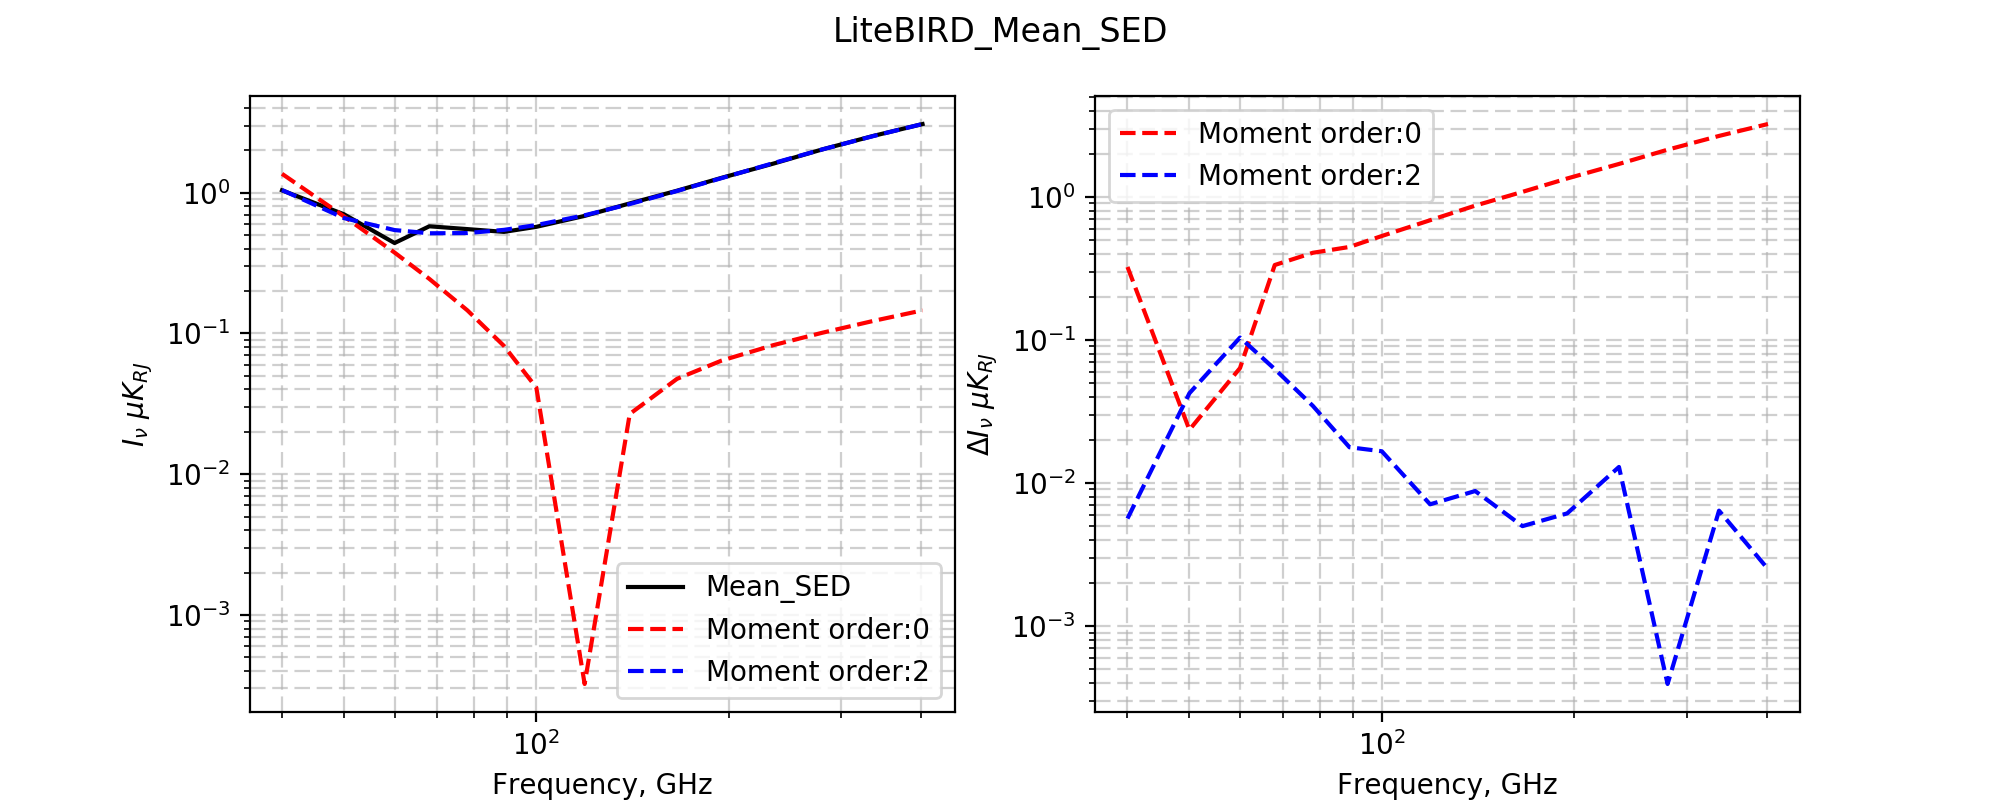

<IPython.core.display.Javascript object>


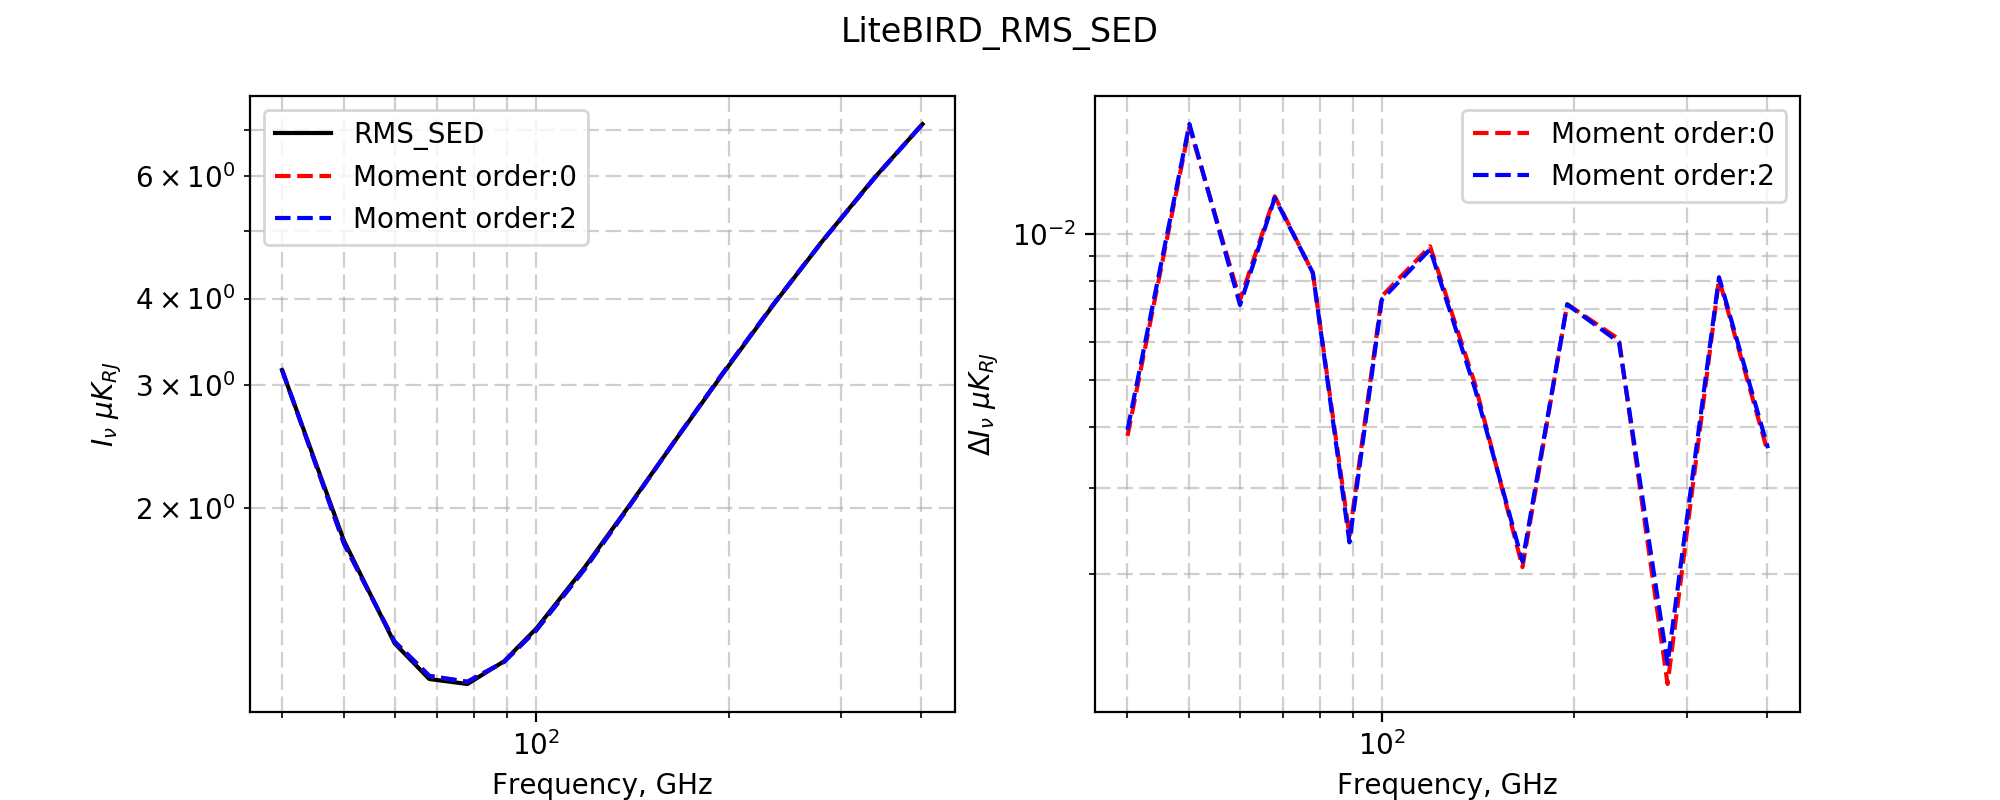

<IPython.core.display.Javascript object>


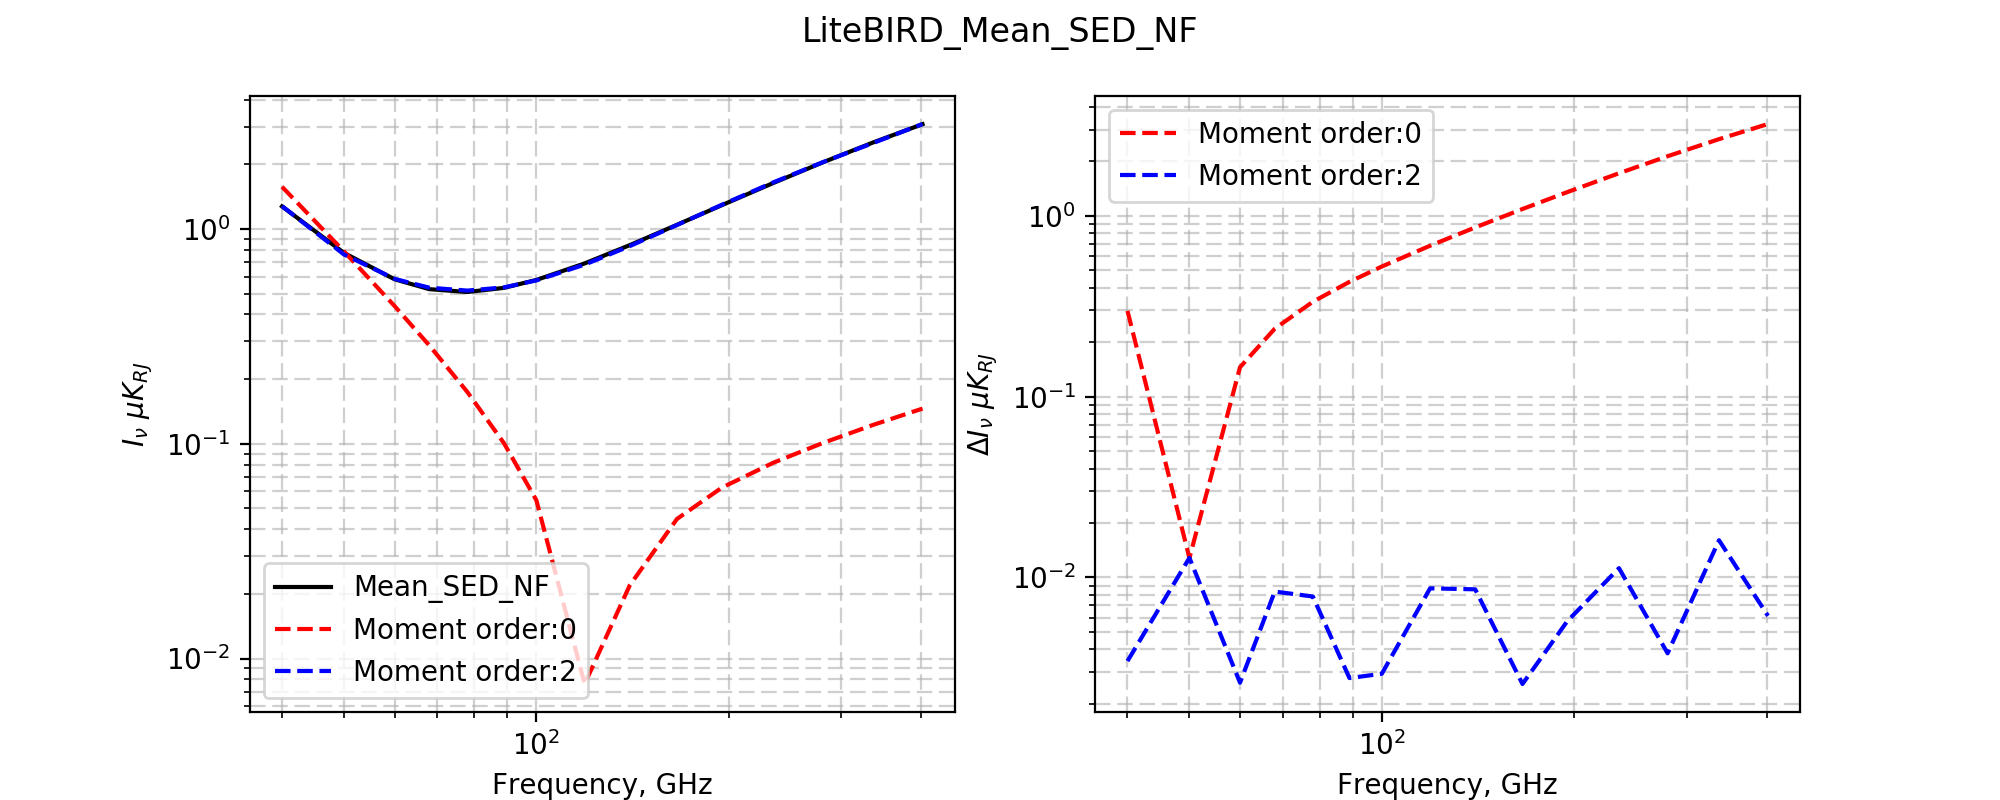

In [58]:
color={}
color[0]="r"
color[2]="b"
for sim in simulations:
    for stype in sed_type:
        ttl=sim + "_" + stype.replace(" ","_")
        chnls=sed[sim]["channels"]
        fig, ax = subplots(nrows=1, ncols=2, figsize=(10, 4),sharey=False)
        ax[0].plot(chnls,abs(sed[sim][stype]),"k-",label=stype.replace(" ","_"))
#         ax[0].plot(chnls,abs(sed[sim]["SED ERR"]),"k--",label="SED ERR")
        for fo in fit_order:
            params=pivots[sim][stype][fo]
            ax[0].plot(chnls,abs(fn[fo](chnls,*params)),"--",c=color[fo],label="Moment order:" + str(fo))
        ax[0].loglog()
        ax[0].legend(loc=0)
        ax[0].set_ylabel(r"$I_{\nu}$ $\mu K_{RJ}$")
        ax[0].set_xlabel("Frequency, GHz")
        ax[0].grid(alpha=0.6,linestyle="dashed",which="both")
        for fo in fit_order:
            params=pivots[sim][stype][fo]
            ax[1].plot(chnls,abs(fn[fo](chnls,*params)-sed[sim][stype]),"--",c=color[fo],label="Moment order:" + str(fo))
        ax[1].loglog()
        ax[1].set_ylabel(r"$\Delta I_{\nu}$ $\mu K_{RJ}$")
        ax[1].set_xlabel("Frequency, GHz")
        ax[1].legend(loc=0)
        ax[1].grid(alpha=0.6,linestyle="dashed",which="both")
        fig.suptitle(ttl)
        filename=figpath + "fit_" + ttl + ".pdf"
        savefig(filename,bbox_inches="tight")

## Hybrid fitting

In [11]:
figpath="./results/hybrid_fit/"
ensure_dir(figpath)

In [13]:
components=["cmb","sync","dust"]
rsed=return_sed.init_model_sed(components,max_der=3,units="uKRJ",nu_ref_low=1.,normalize=False)

def return_fit_fn(max_der,rms_sed,min_der=2):
    rsed.setup_ana_sed(max_der=max_der,min_der=min_der,beta_dust_max=max_der,sl_dust_max=max_der,sl_sync_max=max_der)
    print rsed.fn_args.keys()
    def fit_sed(nu,data,T_dust=15.,sl_dust=1.53,sl_sync=-0.82):
        sed_dict,sed_mat=calc_sed_mat(nu,T_dust=T_dust,sl_dust=sl_dust,sl_sync=sl_sync)
        amp_qr=qr_solve_moments(data,sed_mat)
        rec_data=reconstruct_data(nu,amp_qr,sed_dict)
        return rec_data,amp_qr,sed_dict

    def calc_sed_mat(nu,T_dust=21.,sl_dust=1.53,sl_sync=-0.82):
        sed=collections.OrderedDict()
        sed_mat=np.zeros((len(nu),len(rsed.fn_sed.keys())),np.float64)
        for i,comp in enumerate(rsed.fn_sed.keys()):
            if "dust" in comp:
                sed[comp]=rsed.fn_sed[comp](nu,1.,1./T_dust,sl_dust)
            elif "sync" in comp:
                sed[comp]=rsed.fn_sed[comp](nu,1.,sl_sync)
            elif "cmb" in comp:
                sed[comp]=rsed.fn_sed[comp](nu,1.)
            sed_mat[:,i]=sed[comp]
        return sed,sed_mat

    def qr_solve_moments(data,sed_mat):
        q,r=np.linalg.qr(sed_mat)
        dvec=np.matmul(np.transpose(q),data)
        mom_soln=np.linalg.solve(r,dvec)

        amp_qr={}
        for i,comp in enumerate(rsed.fn_sed.keys()):
            amp_qr[comp]=mom_soln[i]
        return amp_qr

    def reconstruct_data(nu,amp_qr,sed_dict):
        rec_data=np.zeros_like(nu)
        for comp in amp_qr.keys():
            rec_data = rec_data + amp_qr[comp]*sed_dict[comp]
        return rec_data

    fn_fit=lambda nu,T_dust,sl_dust,sl_sync : fit_sed(nu,rms_sed,T_dust,sl_dust,sl_sync)[0]
    fn_fit_ext=lambda nu,T_dust,sl_dust,sl_sync : fit_sed(nu,rms_sed,T_dust,sl_dust,sl_sync)
    return fn_fit,fn_fit_ext

In [87]:
fo=0
sim="PICO"
stype="RMS SED"
def temp_fn((pars)):
    chi2=-0.5*np.sum((fn[fo](sed[sim]["channels"],*pars)-sed[sim][stype]))
    return chi2

# chnls=sed[sim]["channels"]
# amp_scale=1e5
# data_sed=sed[sim][stype] + np.random.normal(loc=0,scale=sed[sim]["SED ERR"]*amp_scale)
# data_err=sed[sim]["SED ERR"]*amp_scale

# figure()
# plot(chnls,data_sed)

In [90]:
temp_fn(pivots[sim][stype][fo])
temp_fn(guess[fo])

59.376145807020691

In [89]:
optz.minimize(temp_fn,x0=np.array(guess[fo]))

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in double_scalars
  """


OverflowError: (34, 'Result too large')

In [64]:
columns=["Simulation","SED Type","Moment order",r"$T_{\rm dust}$",r"$\beta_{\rm dust}$",r"$\beta_{\rm sync.}$"]
hresult=collections.OrderedDict()
for tag in columns:
    hresult[tag]=[]
  
fit_order=[0,2]

hpivots={}
for sim in simulations:
    hpivots[sim]={}
    for stype in sed_type:
        hpivots[sim][stype]={}
        guess_pivots=None
        for fo in fit_order:
            hresult["Simulation"]=hresult["Simulation"] + [sim]
            hresult["SED Type"]=hresult["SED Type"] + [stype]
            hresult["Moment order"]=hresult["Moment order"] + [fo]
            fn_fit=return_fit_fn(fo,sed[sim][stype],min_der=1)[0]
            p0,p0_cov=curve_fit(fn_fit,
                                sed[sim]["channels"],
                                sed[sim][stype] + np.random.normal(loc=np.zeros(len(sed[sim]["SED ERR"])),scale=sed[sim]["SED ERR"]*1e4),
                                sigma=sed[sim]["SED ERR"],
                                absolute_sigma=True,
                                p0=guess_pivots,
                                bounds=([10.,0.,-2.],[20.,2.,0.]),
                                maxfev=200000)
            hresult[r"$T_{\rm dust}$"]=hresult[r"$T_{\rm dust}$"] + [p0[0]]
            hresult[r"$\beta_{\rm dust}$"]=hresult[r"$\beta_{\rm dust}$"] + [p0[1]]
            hresult[r"$\beta_{\rm sync.}$"]=hresult[r"$\beta_{\rm sync.}$"] + [p0[2]-2]
            guess_pivots=p0[:3]
            hpivots[sim][stype][fo]=p0
            print sim, stype,fo,p0[:3]

['cmb', 'sync', 'dust']
PICO Mean SED 0 [ 20.           1.65468914  -1.11699062]
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
PICO Mean SED 2 [  2.00000000e+01   1.84766742e+00  -1.71946256e-11]
['cmb', 'sync', 'dust']
PICO RMS SED 0 [ 20.           1.51441853  -0.99028341]
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
PICO RMS SED 2 [ 10.24470063   1.84367815  -0.48857696]
['cmb', 'sync', 'dust']
PICO Mean SED NF 0 [ 20.           1.65582758  -1.09175961]
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
PICO Mean SED NF 2 [ 19.86170696   1.92363649  -1.99999998]
['cmb', '

In [65]:
sed[sim]["SED ERR"]

array([  6.06404361e-05,   3.68280662e-05,   2.94852843e-05,
         1.80756473e-05,   1.36490879e-05,   1.13197719e-05,
         7.65428979e-06,   4.76404082e-06,   4.14460449e-06,
         3.90719550e-06,   3.49352414e-06,   4.31137535e-06,
         3.56928152e-06,   2.80255139e-06,   2.84705666e-06])

In [66]:
hfit_stat=pd.DataFrame(hresult)
hfit_stat.set_index(["Simulation","SED Type"],inplace=True)
hfit_stat

Moment order  $T_{\rm dust}$  $\beta_{\rm dust}$  \
Simulation SED Type                                                        
PICO       Mean SED                0       20.000000        1.654689e+00   
           Mean SED                2       20.000000        1.847667e+00   
           RMS SED                 0       20.000000        1.514419e+00   
           RMS SED                 2       10.244701        1.843678e+00   
           Mean SED NF             0       20.000000        1.655828e+00   
           Mean SED NF             2       19.861707        1.923636e+00   
PICO_MHD   Mean SED                0       13.706853        1.506070e+00   
           Mean SED                2       19.439825        1.856405e+00   
           RMS SED                 0       20.000000        1.505937e+00   
           RMS SED                 2       13.948888        2.000000e+00   
           Mean SED NF             0       12.937625        1.577917e+00   
           Mean SED NF             2       18.372411        2.000000e+00   
LiteBIRD   Mean SED                0       12.353206        2.000000e+00   
           Mean SED                2       10.000000        1.374168e-16   
           RMS SED                 0       20.000000        1.495809e+00   
           RMS SED                 2       19.971196        1.999999e+00   
           Mean SED NF             0       20.000000        1.581960e+00   
           Mean SED NF             2       10.002069        1.999994e+00   

                        $\beta_{\rm sync.}$  
Simulation SED Type                          
PICO       Mean SED               -3.116991  
           Mean SED               -2.000000  
           RMS SED                -2.990283  
           RMS SED                -2.488577  
           Mean SED NF            -3.091760  
           Mean SED NF            -4.000000  
PICO_MHD   Mean SED               -2.954143  
           Mean SED               -3.999996  
           RMS SED                -2.967583  
           RMS SED                -3.858044  
           Mean SED NF            -2.995037  
           Mean SED NF            -4.000000  
LiteBIRD   Mean SED               -3.518013  
           Mean SED               -4.000000  
           RMS SED                -3.194315  
           RMS SED                -3.999703  
           Mean SED NF            -2.440040  
           Mean SED NF            -2.776434

<IPython.core.display.Javascript object>


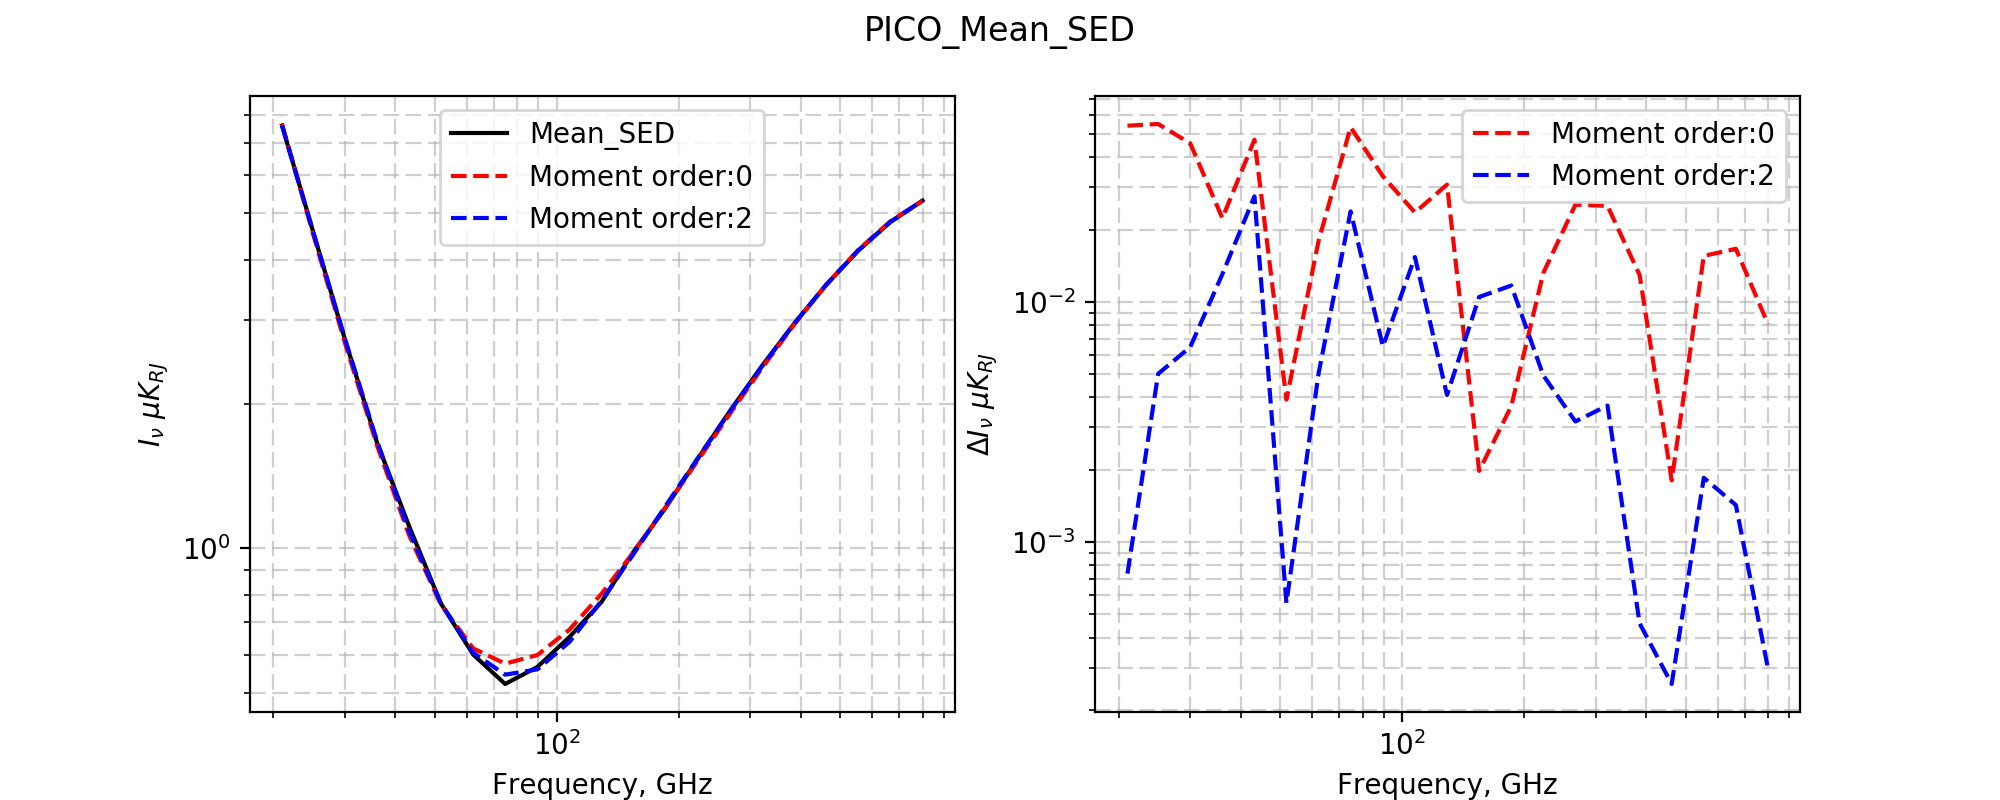

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


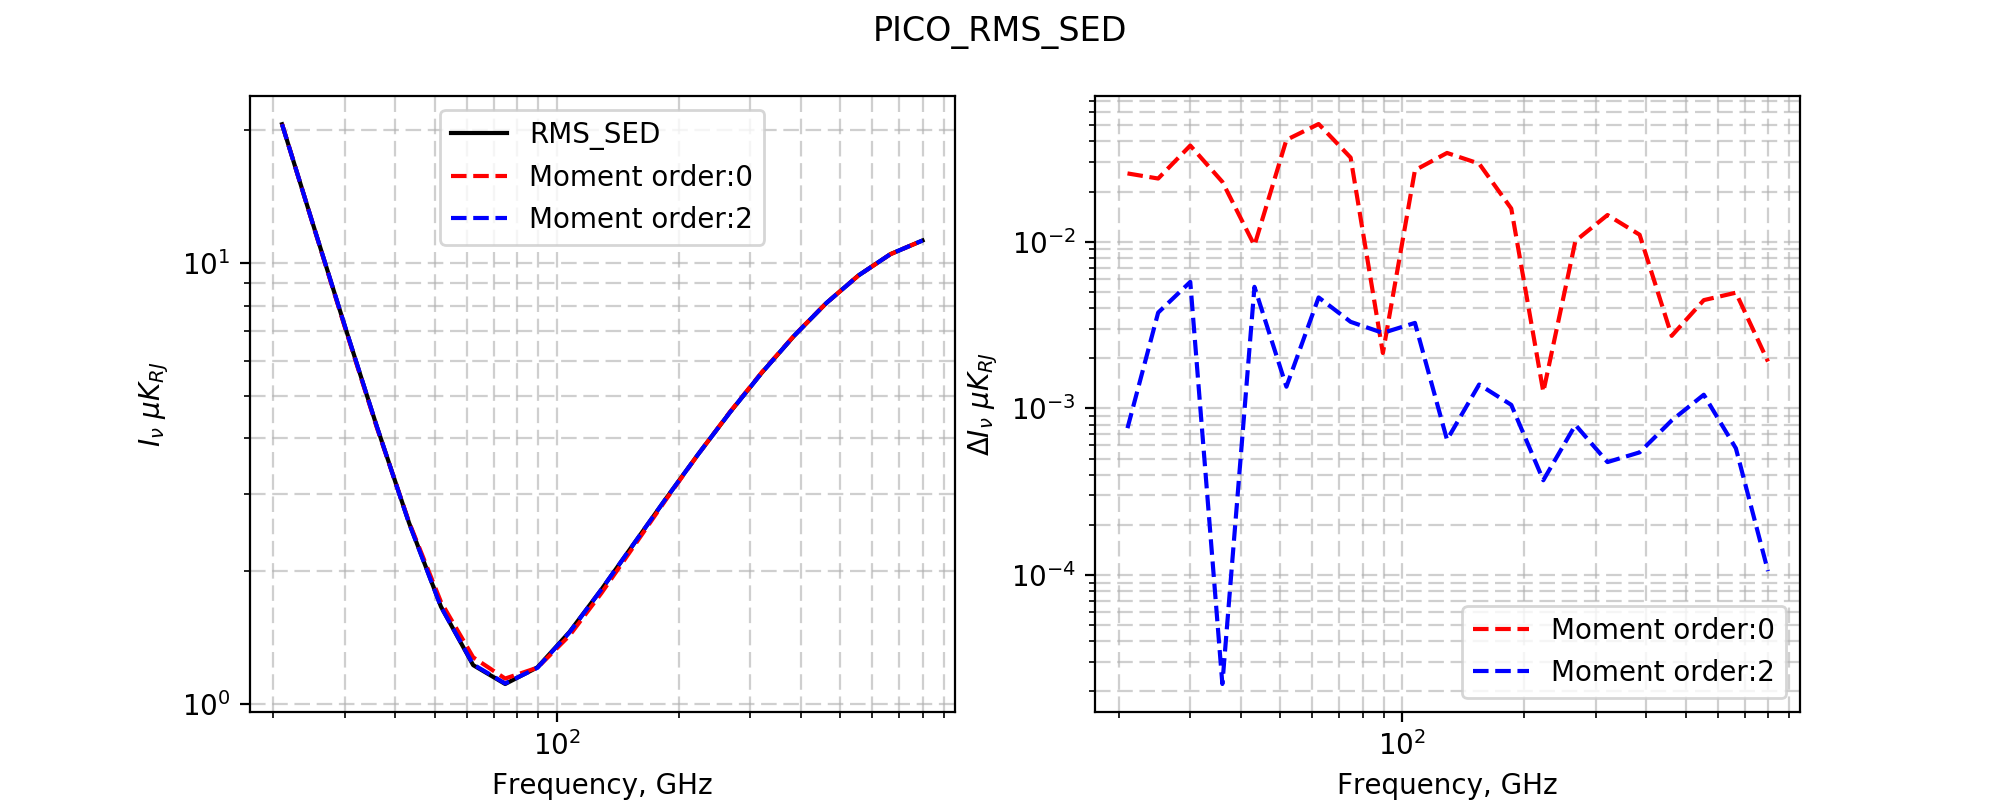

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


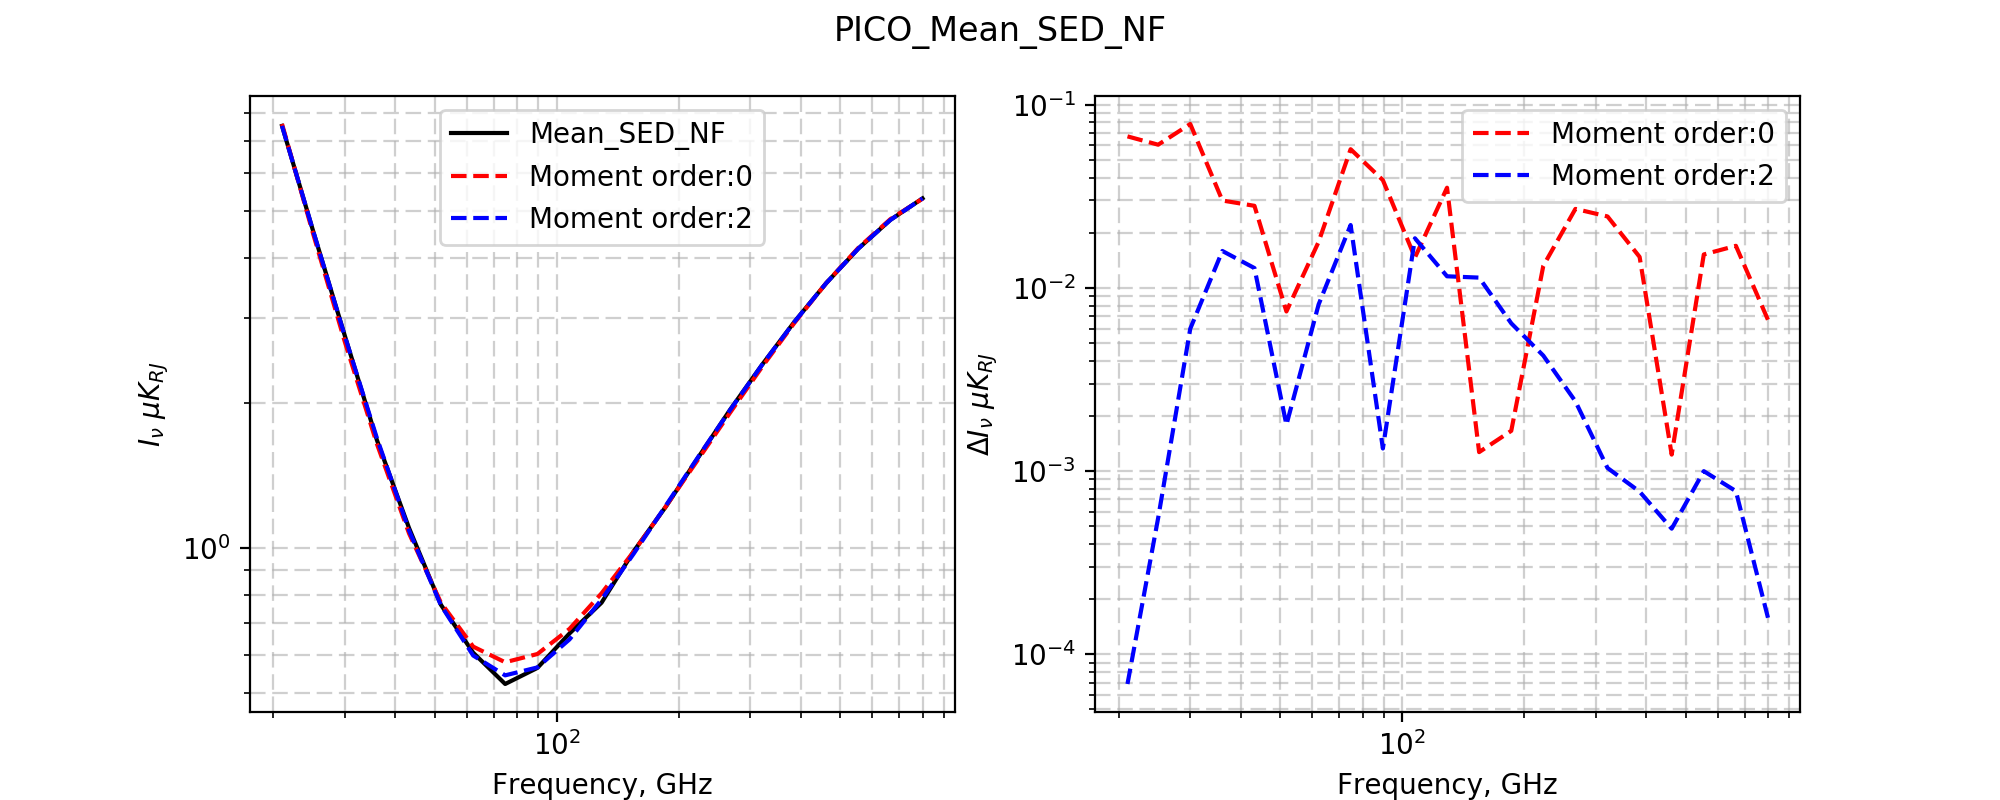

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


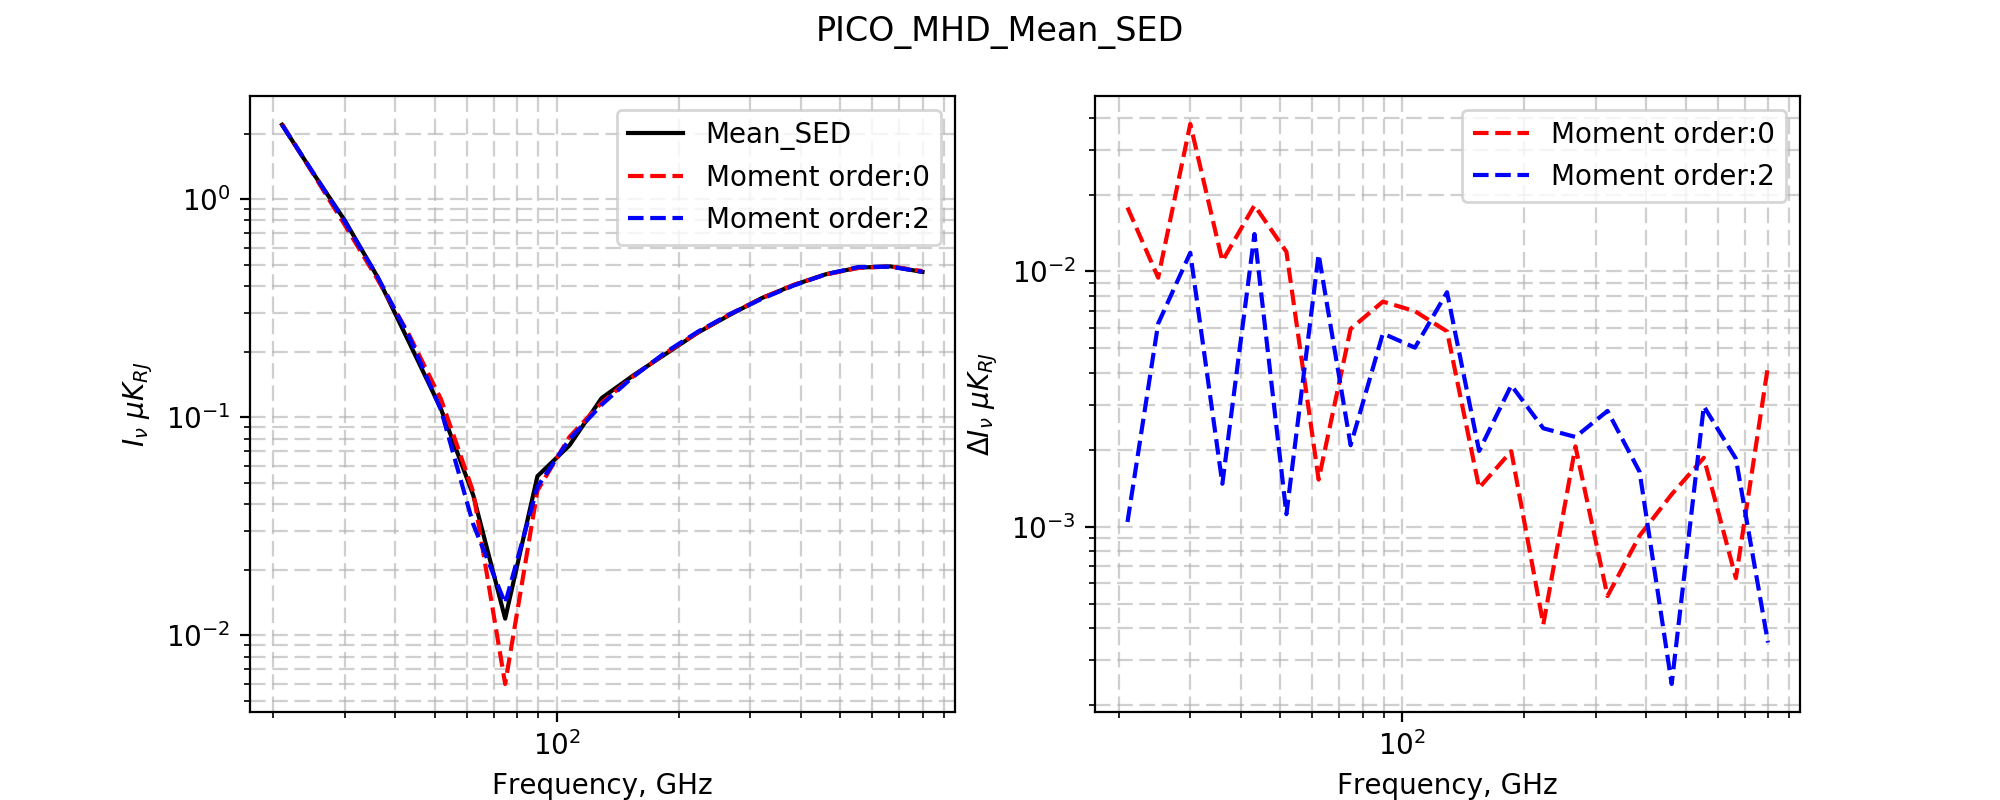

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


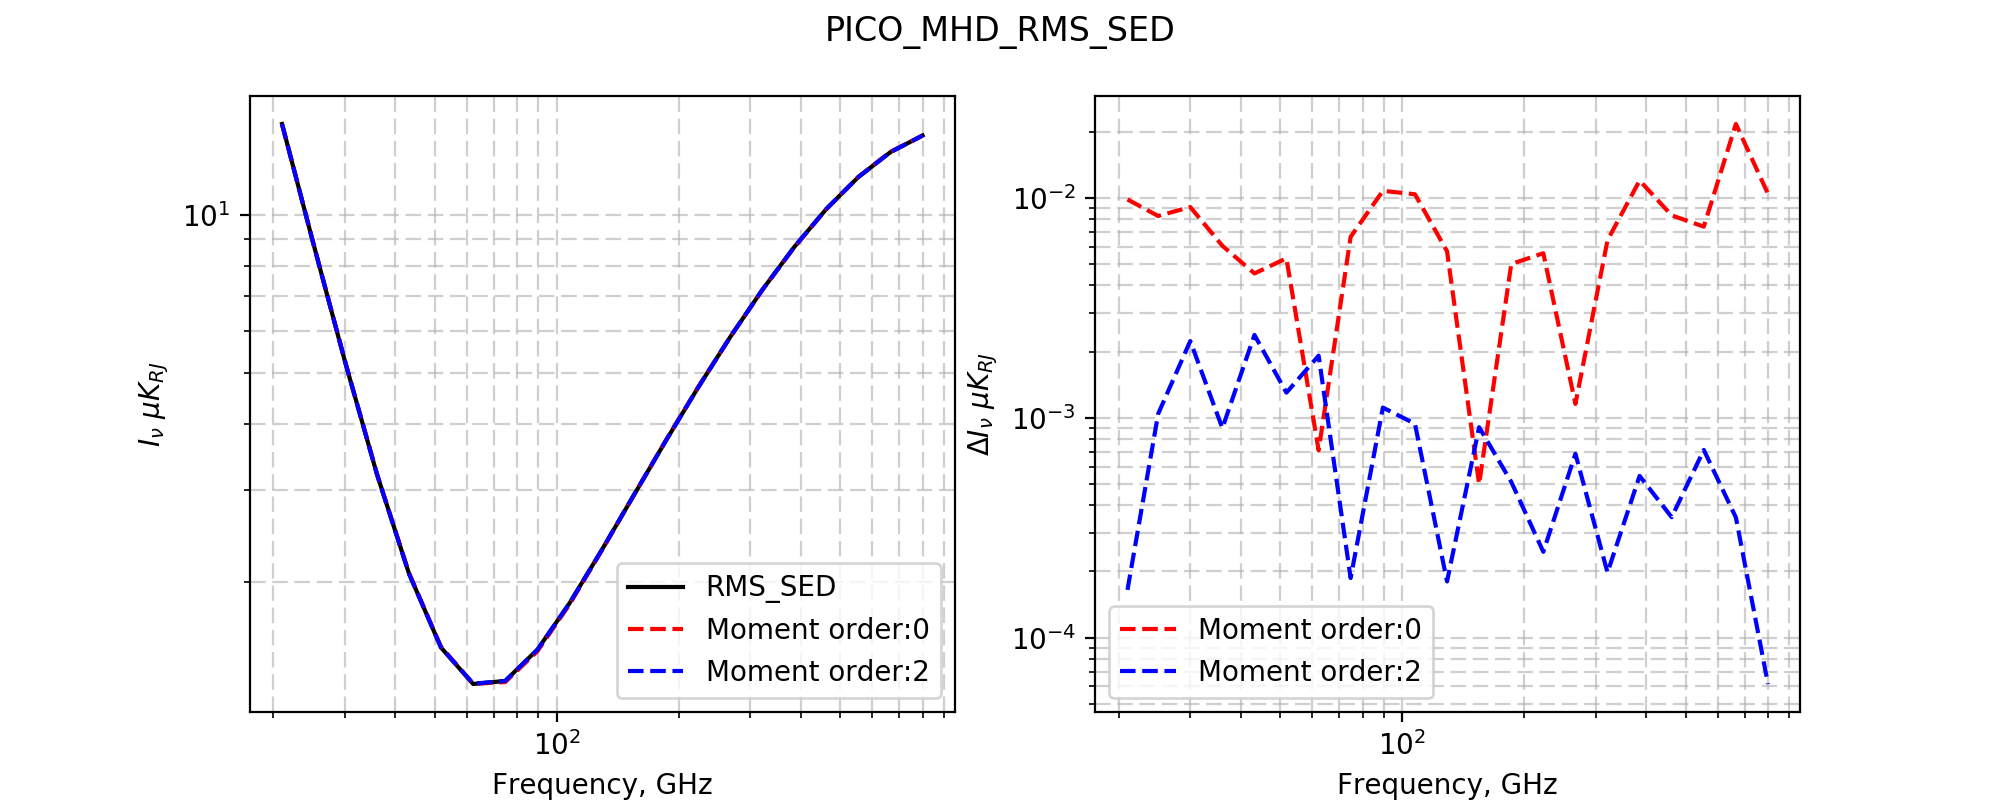

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


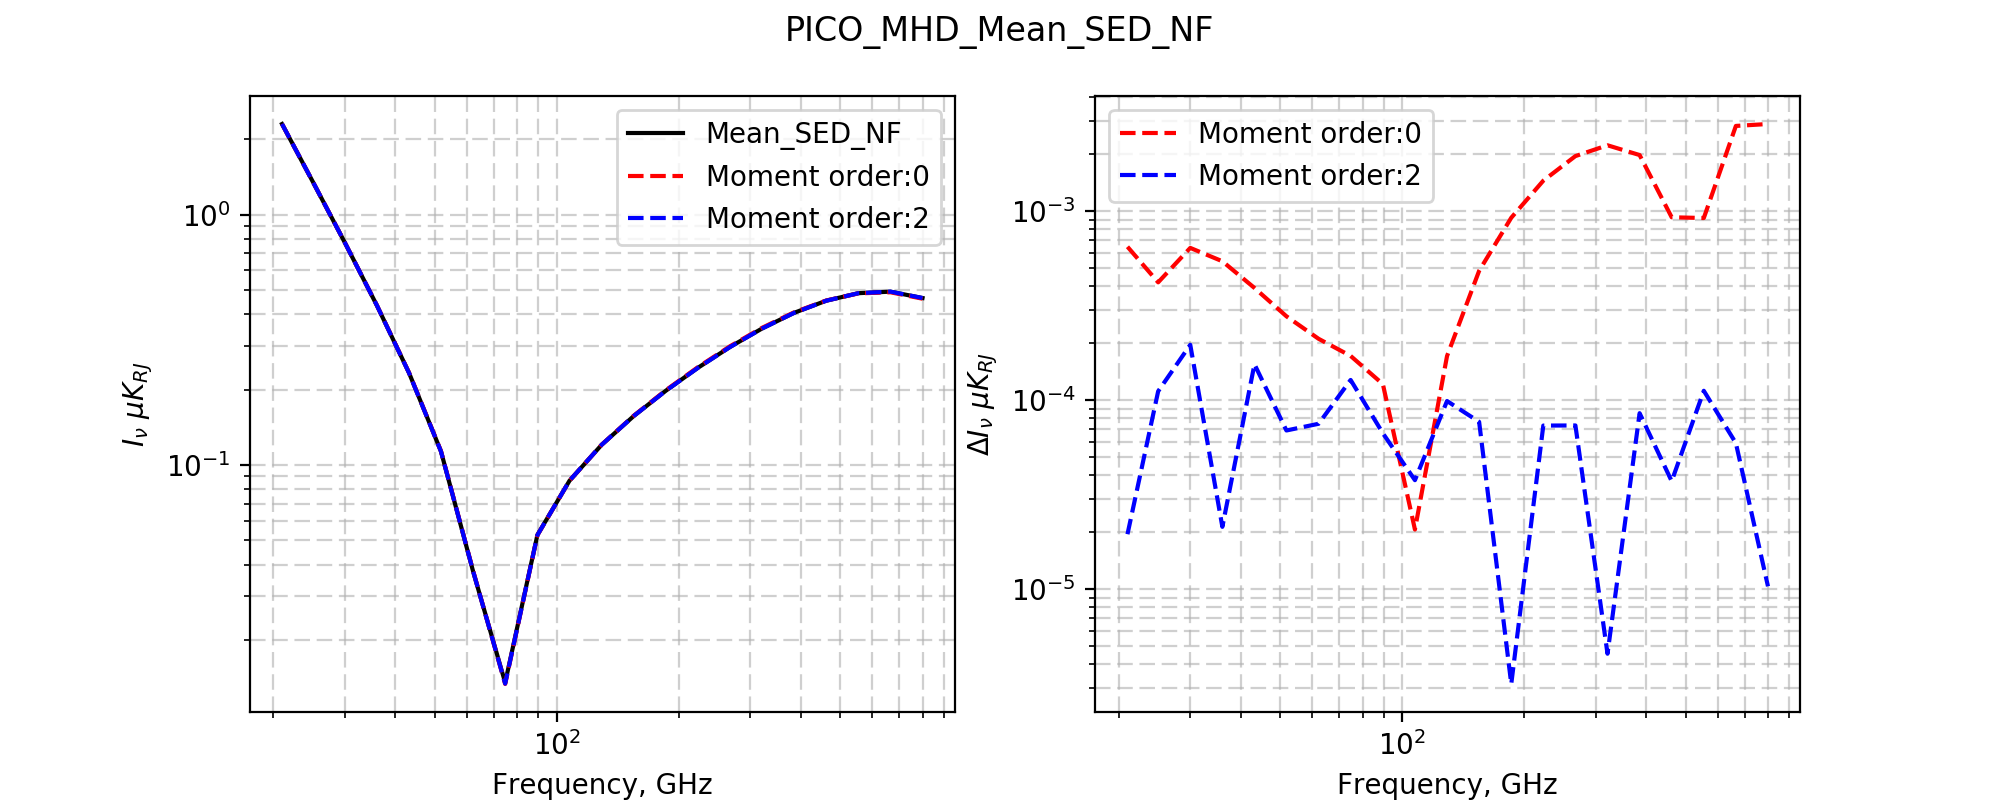

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


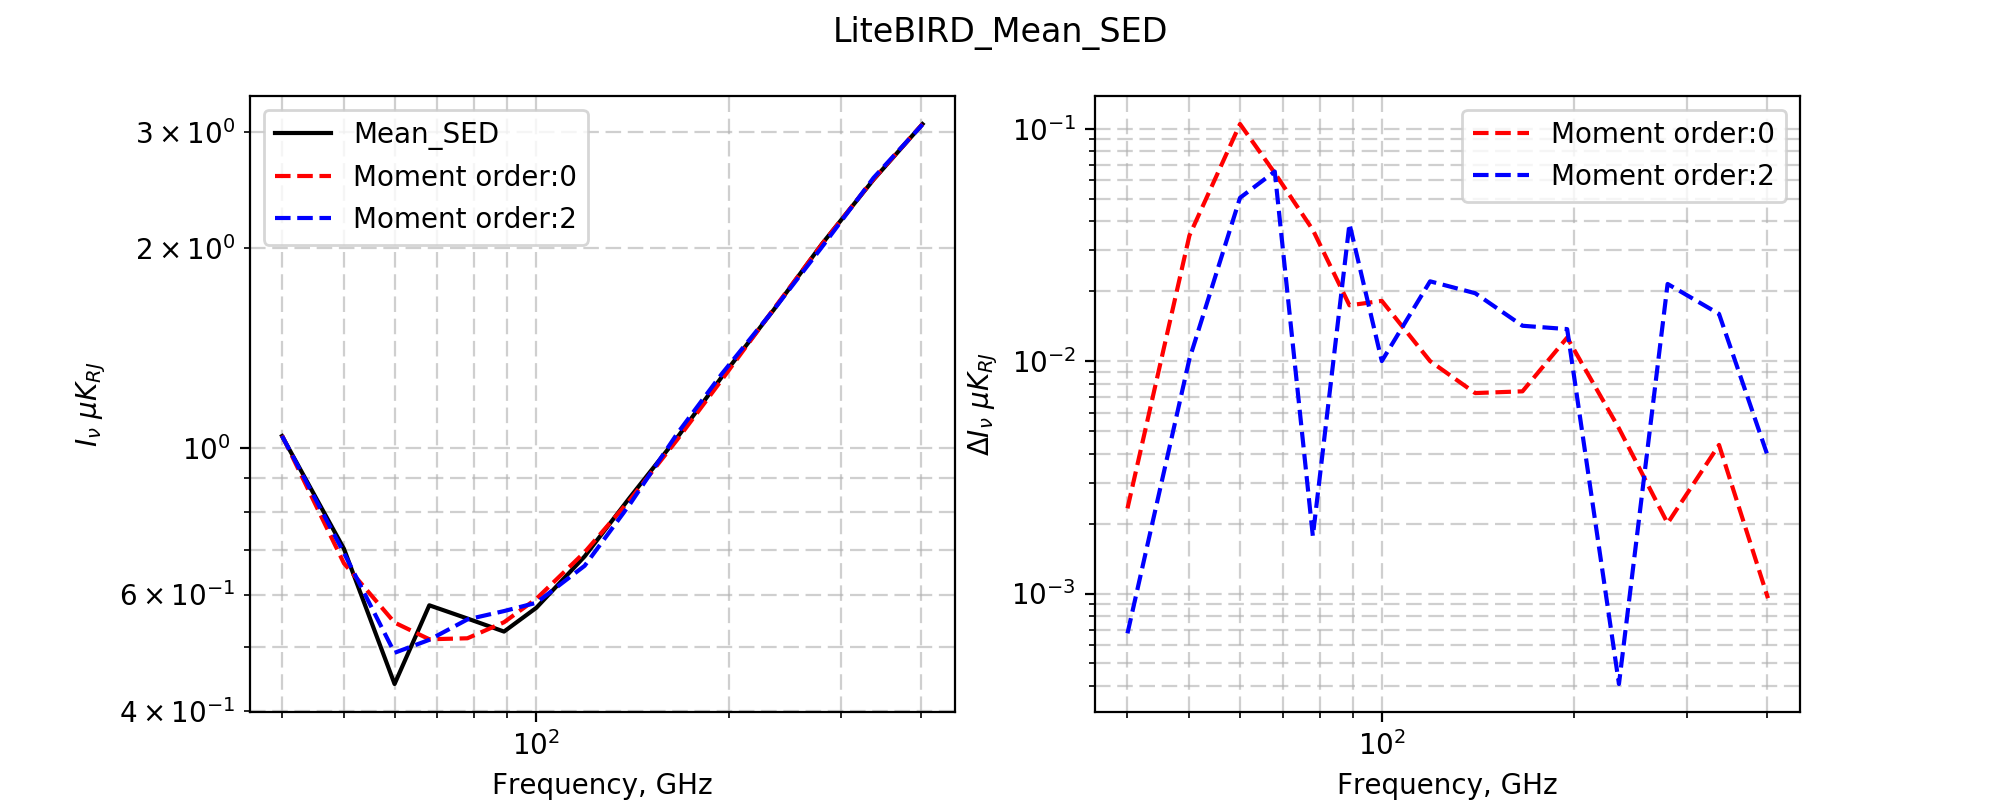

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


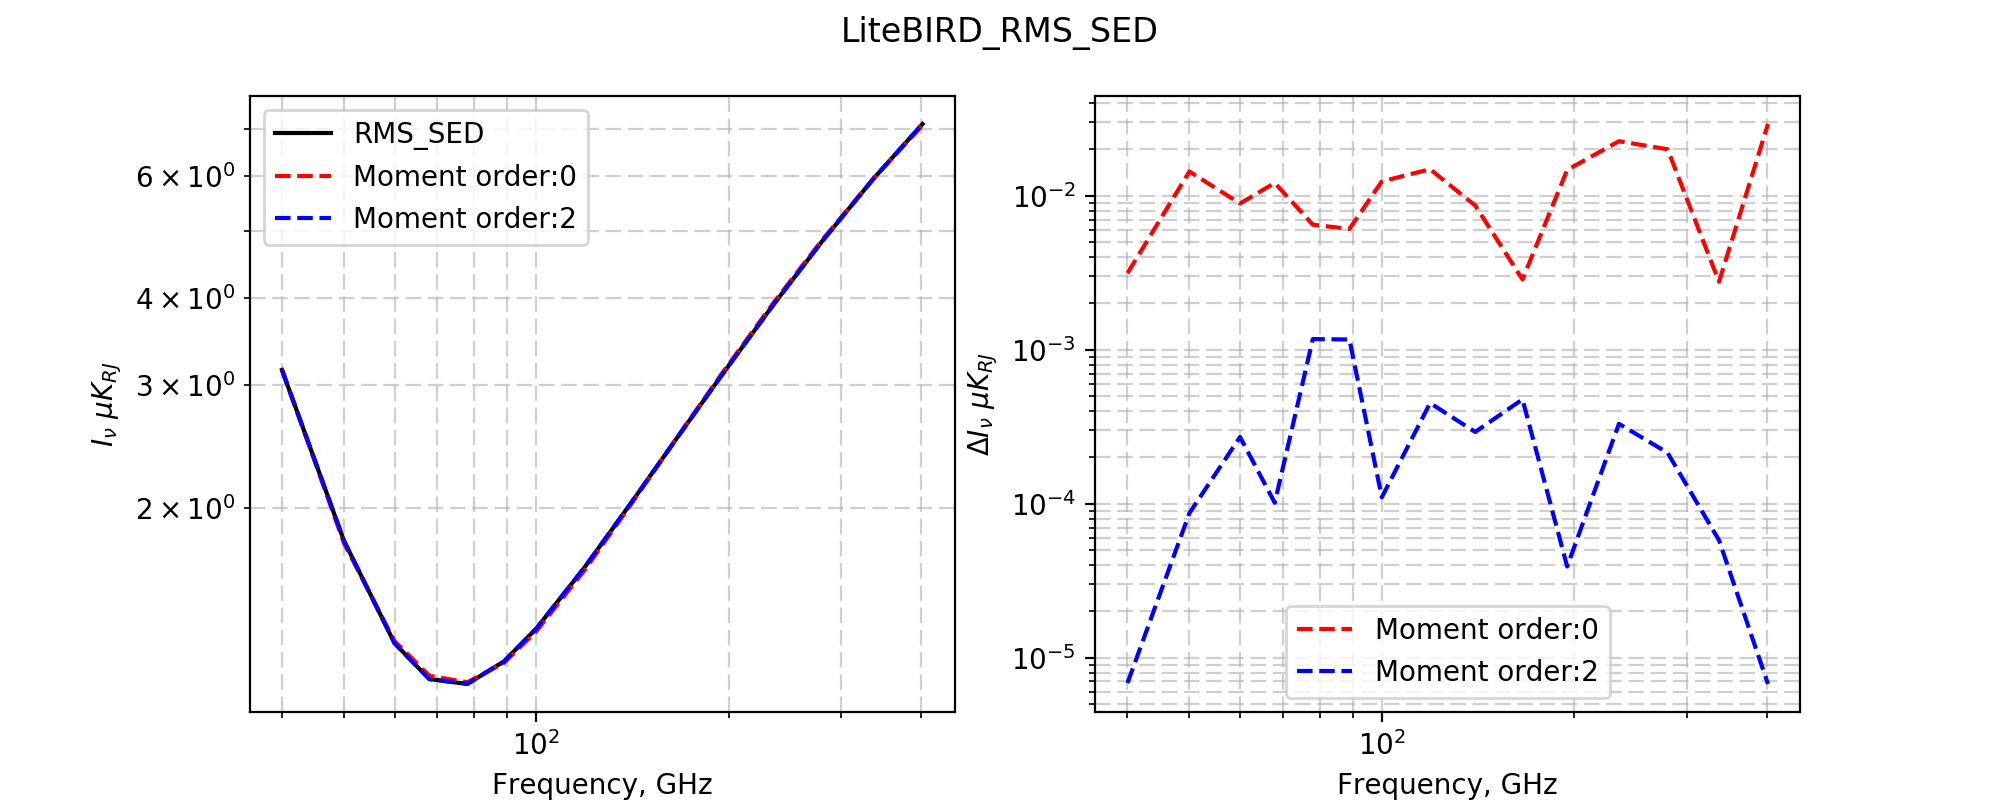

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


<IPython.core.display.Javascript object>


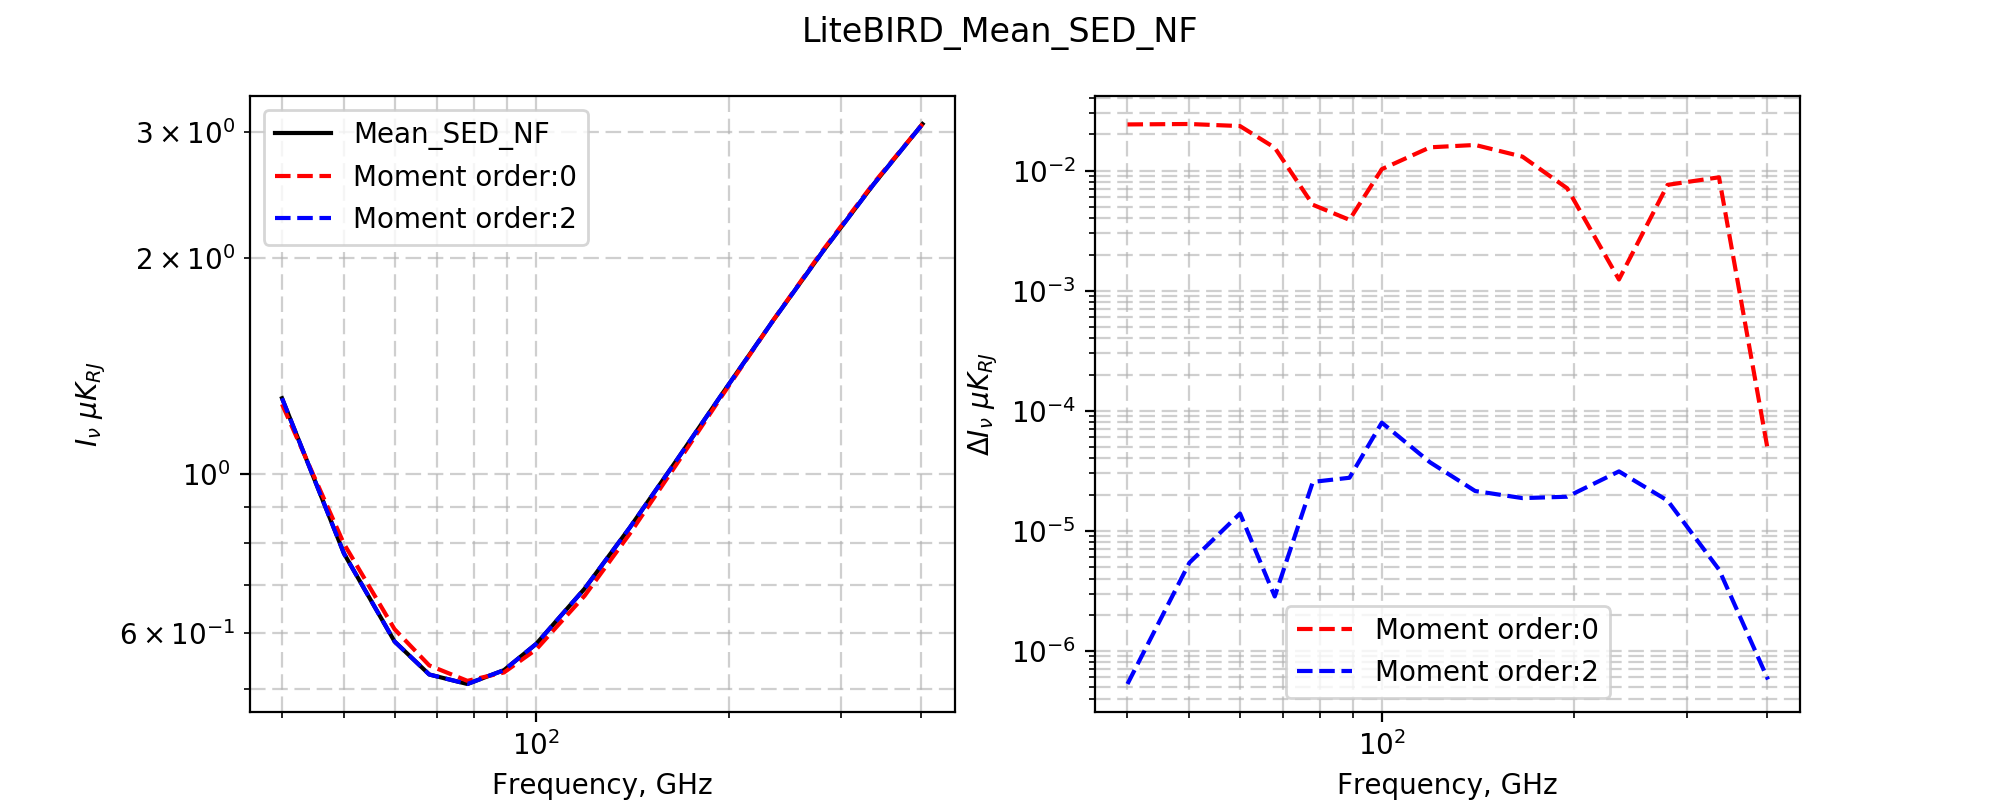

['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']
['cmb', 'sync', 'dust']
['cmb', 'sync', 'dust', 'beta_dust_00_sl_dust_01', 'beta_dust_01_sl_dust_00', 'beta_dust_00_sl_dust_02', 'beta_dust_01_sl_dust_01', 'beta_dust_02_sl_dust_00', 'sl_sync_01', 'sl_sync_02']


In [67]:
color={}
color[0]="r"
color[2]="b"
color[3]="g"
for sim in simulations:
    for stype in sed_type:
        ttl=sim + "_" + stype.replace(" ","_")
        chnls=sed[sim]["channels"]
        fig, ax = subplots(nrows=1, ncols=2, figsize=(10, 4),sharey=False)
        ax[0].plot(chnls,abs(sed[sim][stype]),"k-",label=stype.replace(" ","_"))
#         ax[0].plot(chnls,abs(sed[sim]["SED ERR"]),"k--",label="SED ERR")
        for fo in fit_order:
            fn_fit=return_fit_fn(fo,sed[sim][stype],min_der=1)[0]
            params=hpivots[sim][stype][fo]
            ax[0].plot(chnls,abs(fn_fit(chnls,*params)),"--",c=color[fo],label="Moment order:" + str(fo))
        ax[0].loglog()
        ax[0].legend(loc=0)
        ax[0].set_ylabel(r"$I_{\nu}$ $\mu K_{RJ}$")
        ax[0].set_xlabel("Frequency, GHz")
        ax[0].grid(alpha=0.6,linestyle="dashed",which="both")
        for fo in fit_order:
            fn_fit=return_fit_fn(fo,sed[sim][stype],min_der=1)[0]
            params=hpivots[sim][stype][fo]
            ax[1].plot(chnls,abs(fn_fit(chnls,*params)-sed[sim][stype]),"--",c=color[fo],label="Moment order:" + str(fo))
        ax[1].loglog()
        ax[1].set_ylabel(r"$\Delta I_{\nu}$ $\mu K_{RJ}$")
        ax[1].set_xlabel("Frequency, GHz")
        ax[1].legend(loc=0)
        ax[1].grid(alpha=0.6,linestyle="dashed",which="both")
        fig.suptitle(ttl)
        filename=figpath + "fit_" + ttl + ".pdf"
        savefig(filename,bbox_inches="tight")